In [1]:
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale, StandardScaler

In [2]:
class Topsis:
    def __init__(self, X, weights, criteria):
        self.X = np.asarray(X, dtype="float64")
        self.weights = np.asarray(weights, dtype="float64")
        self.weights /= np.sum(self.weights)
        self.criteria = np.asarray(criteria, dtype=bool)
        self._fitted = False

    def fit(self):
        X_norm = self.X.copy()
        norm_coefs = np.sum(X_norm**2, axis=0) ** 0.5
        X_norm /= norm_coefs
        X_norm *= self.weights

        # Determine the best and worst alternatives
        X_min, X_max = X_norm.min(axis=0), X_norm.max(axis=0)
        best = np.where(self.criteria, X_max, X_min)
        worst = np.where(self.criteria, X_min, X_max)

        # Determine the best and worst distances
        self.best_distance = np.sum((X_norm - best) ** 2, axis=1) ** 0.5
        self.worst_distance = np.sum((X_norm - worst) ** 2, axis=1) ** 0.5
        self._fitted = True

    def predict(self):
        if not self._fitted:
            raise ValueError("The model has not been fitted yet")
        denom = self.best_distance + self.worst_distance
        return self.best_distance / denom, self.worst_distance / denom

    def fit_predict(self):
        if not self._fitted:
            self.fit()
        return self.predict()

In [3]:
def get_performance(df, match_id):
    match_df = df[df["match_id"] == match_id]
    eval_df = match_df.copy()

    # Explode the columns to duplicate columns for each player
    eval_df["player_id"] = None
    for i in eval_df.index:
        eval_df.at[i, "player_id"] = (1, 2)
    eval_df = (
        eval_df.explode("player_id")
        .reset_index(names="point_id")
        .set_index(["point_id", "player_id"])
    )

    # Assign info to the corresponding player
    sep_cols = ["ace", "winner", "break_pt_won", "double_fault", "unf_err"]
    eval_df_spec_criteria = [True, True, True, False, False]
    for col in sep_cols:
        eval_df[col] = eval_df.apply(lambda x: x[f"p{x.name[1]}_{col}"], axis=1)

    # Victor by server or receiver
    eval_df["victor_by_server"] = eval_df.apply(
        lambda x: int(x["point_victor"] == x.name[1] and x["server"] == x.name[1]),
        axis=1,
    )
    eval_df["victor_by_receiver"] = eval_df.apply(
        lambda x: int(x["point_victor"] == x.name[1] and x["server"] != x.name[1]),
        axis=1,
    )
    sep_cols = ["victor_by_server", "victor_by_receiver"] + sep_cols
    eval_df_spec_criteria = [True, True] + eval_df_spec_criteria

    # Entropy weight method (EWM)
    eval_df_spec = eval_df[sep_cols]
    scaled_values = minmax_scale(eval_df_spec.values, feature_range=(0.01, 0.99))
    norm_values = scaled_values / np.sum(scaled_values, axis=0)
    g = 1 + 1 / np.log(len(eval_df_spec)) * np.sum(
        norm_values * np.log(norm_values), axis=0
    )
    eval_df_spec_weights = g / np.sum(g)

    # TOPSIS
    topsis = Topsis(eval_df_spec.values, eval_df_spec_weights, eval_df_spec_criteria)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        eval_df_spec["performance"] = topsis.fit_predict()[1]

    # Store performance data
    p1_performance = eval_df_spec.loc[
        eval_df_spec.index.get_level_values("player_id") == 1, "performance"
    ]
    p2_performance = eval_df_spec.loc[
        eval_df_spec.index.get_level_values("player_id") == 2, "performance"
    ]
    p1_performance.index = p1_performance.index.droplevel("player_id")
    p2_performance.index = p2_performance.index.droplevel("player_id")
    return pd.concat([p1_performance, p2_performance], axis=1, keys=["p1", "p2"])

In [4]:
df = pd.read_csv("wimbledon.csv")

In [5]:
window_size = 6

Define the function for plotting match information, including performance, momentum, and points.

In [6]:
def plot_match_info(df, *, n_samples, window_size, random_state):
    # n_samples : None -> all matches
    #           : int  -> n random matches
    #           : list -> matches in the list, prefixed with "2023-wimbledon-"
    rng = np.random.RandomState(random_state)
    if isinstance(n_samples, list):
        match_ids = [f"2023-wimbledon-{i}" for i in n_samples]
    else:
        match_ids = df["match_id"].unique()
        if n_samples is not None:
            match_ids = rng.choice(match_ids, size=n_samples, replace=False)

    for match_id in match_ids:
        _, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

        # Performance
        df_performance = get_performance(df, match_id)
        ax1.plot(df_performance.index, df_performance["p1"], label="Player 1")
        ax1.plot(df_performance.index, df_performance["p2"], label="Player 2")
        ax1.set_title("Performance", fontsize=10)
        ax1.get_xaxis().set_visible(False)
        ax1.legend(loc="lower right")

        # Momentum
        df_perf_diff = df_performance["p1"] - df_performance["p2"]
        ser_momentum = df_perf_diff.rolling(window_size).sum()
        ser_momentum = ser_momentum.fillna(df_perf_diff.cumsum())
        ax2.plot(ser_momentum.index, ser_momentum, color="black")
        ax2.fill_between(
            ser_momentum.index,
            ser_momentum,
            where=ser_momentum > 0,
            color="tab:blue",
            alpha=0.3,
            interpolate=True,
        )
        ax2.fill_between(
            ser_momentum.index,
            ser_momentum,
            where=ser_momentum < 0,
            color="tab:orange",
            alpha=0.3,
            interpolate=True,
        )
        for i, sign_diff in (
            np.sign(ser_momentum).diff().where(lambda x: x != 0).dropna().items()
        ):
            ax2.axvline(
                i,
                color="tab:orange" if sign_diff < 0 else "tab:blue",
                linestyle="--",
                lw=0.3,
            )
        ax2.set_title("Momentum", fontsize=10)
        ax2.get_xaxis().set_visible(False)

        # Points
        df_points_info = df.loc[
            ser_momentum.index, ["point_victor", "p1_points_won", "p2_points_won"]
        ]
        ser_points_diff = (
            df_points_info["p1_points_won"] - df_points_info["p2_points_won"]
        )
        ax3.fill_between(
            ser_points_diff.index,
            ser_points_diff,
            where=ser_points_diff > 0,
            color="tab:blue",
            alpha=0.1,
            interpolate=True,
        )
        ax3.fill_between(
            ser_points_diff.index,
            ser_points_diff,
            where=ser_points_diff < 0,
            color="tab:orange",
            alpha=0.1,
            interpolate=True,
        )
        ser_victor = df_points_info["point_victor"]
        ser_victor_p1 = ser_victor.copy()
        ser_victor_p1[ser_victor == 1] = 1
        ser_victor_p1[ser_victor != 1] = 0
        ax3.fill_between(
            ser_victor.index,
            ser_victor_p1,
            color="tab:blue",
            step="post",
            alpha=0.5,
        )
        ser_victor_p2 = ser_victor.copy()
        ser_victor_p2[ser_victor == 2] = -1
        ser_victor_p2[ser_victor != 2] = 0
        ax3.fill_between(
            ser_victor.index,
            ser_victor_p2,
            color="tab:orange",
            step="post",
            alpha=0.5,
        )
        ax3.set_ylim(-10, 10)
        ax3.set_title("Points", fontsize=10)
        ax3.get_xaxis().set_visible(False)

        plt.suptitle(f"Match {match_id}")
        plt.tight_layout()
        plt.show()

Plot all matches.

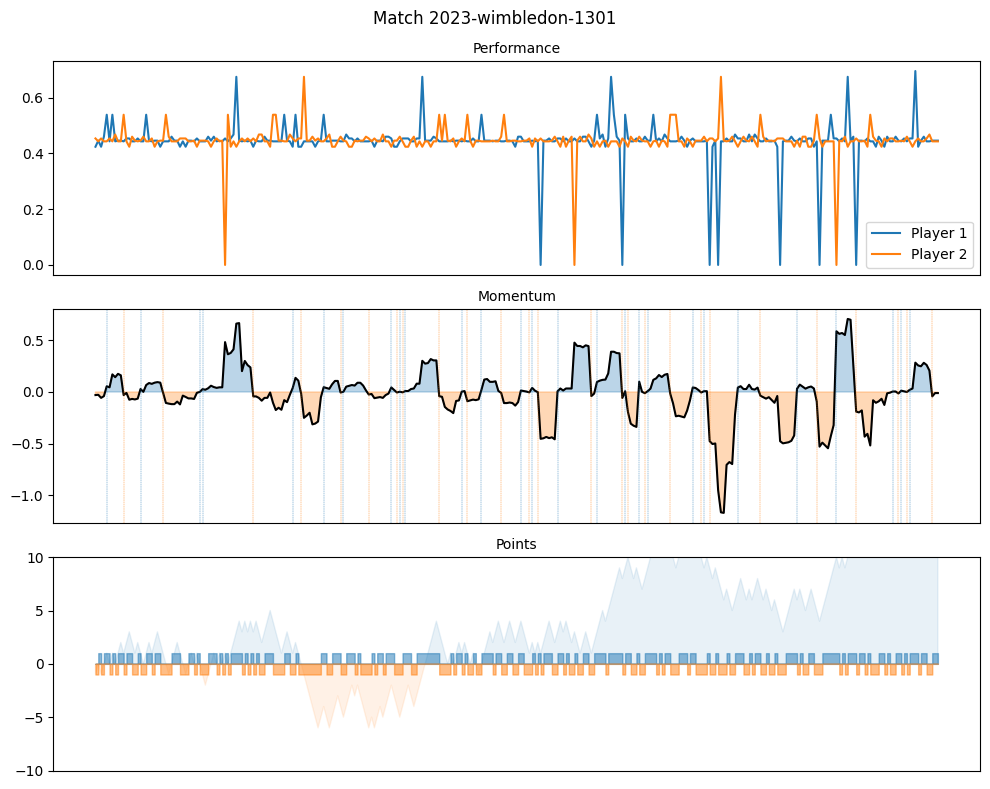

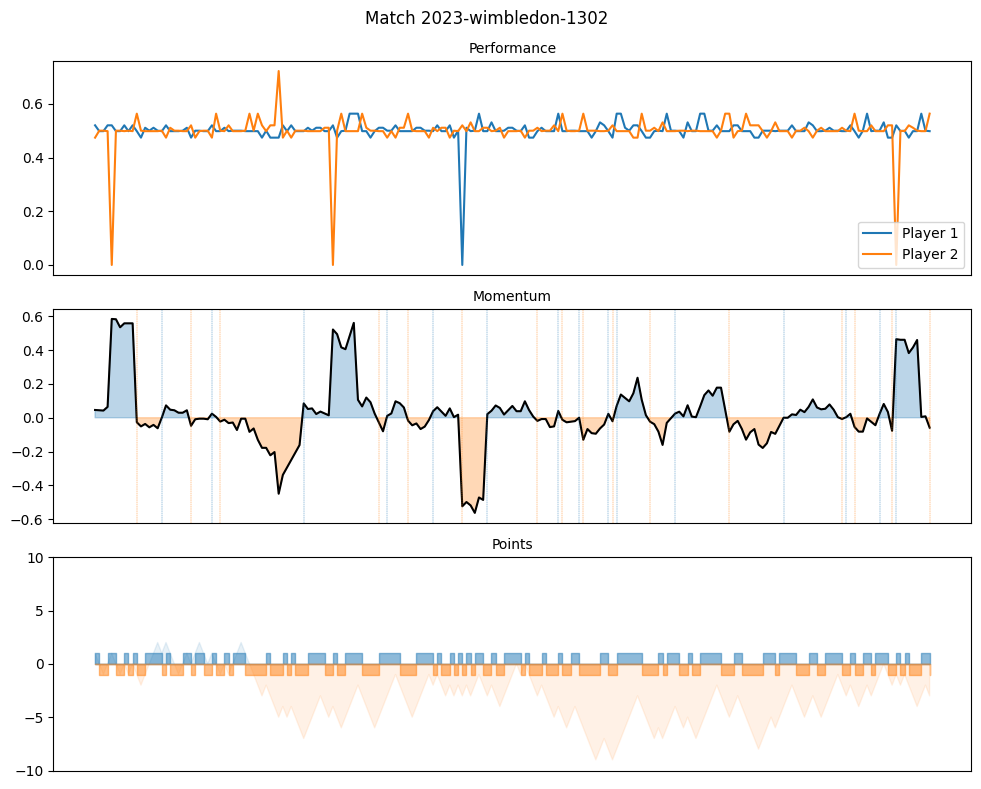

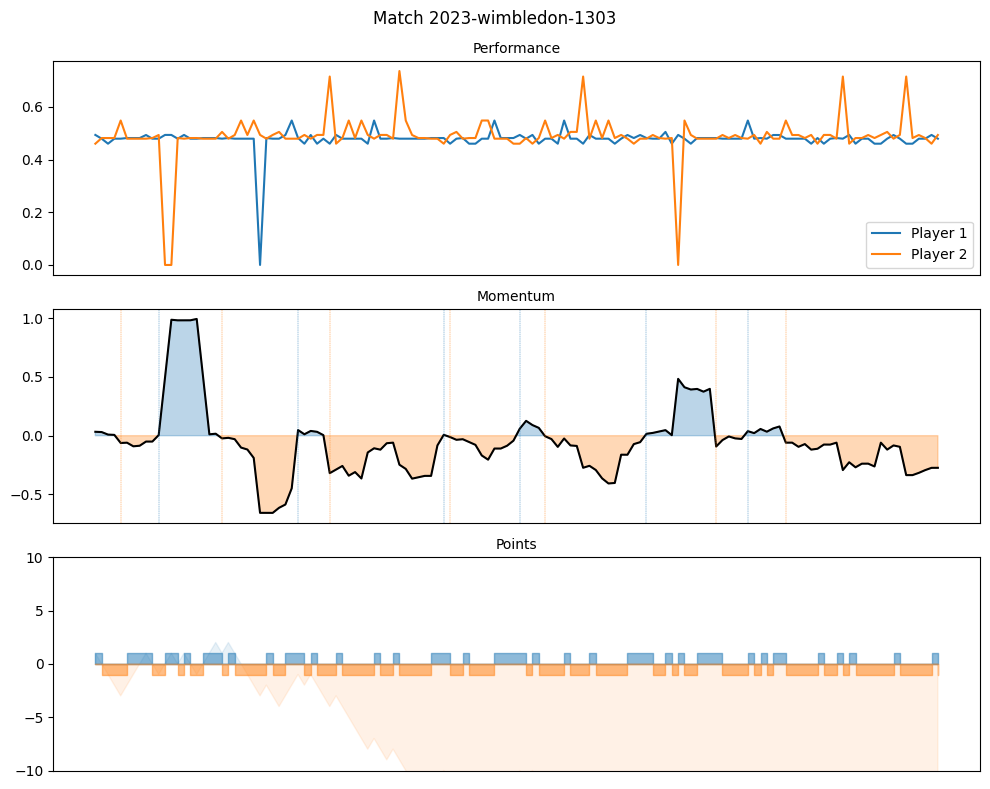

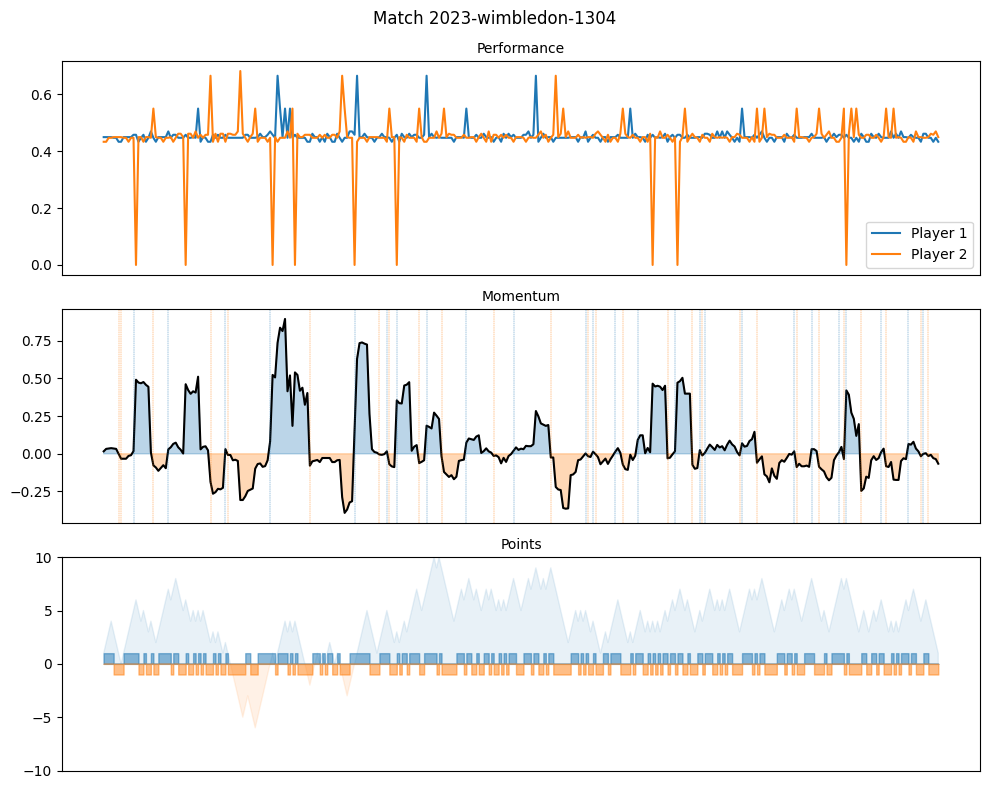

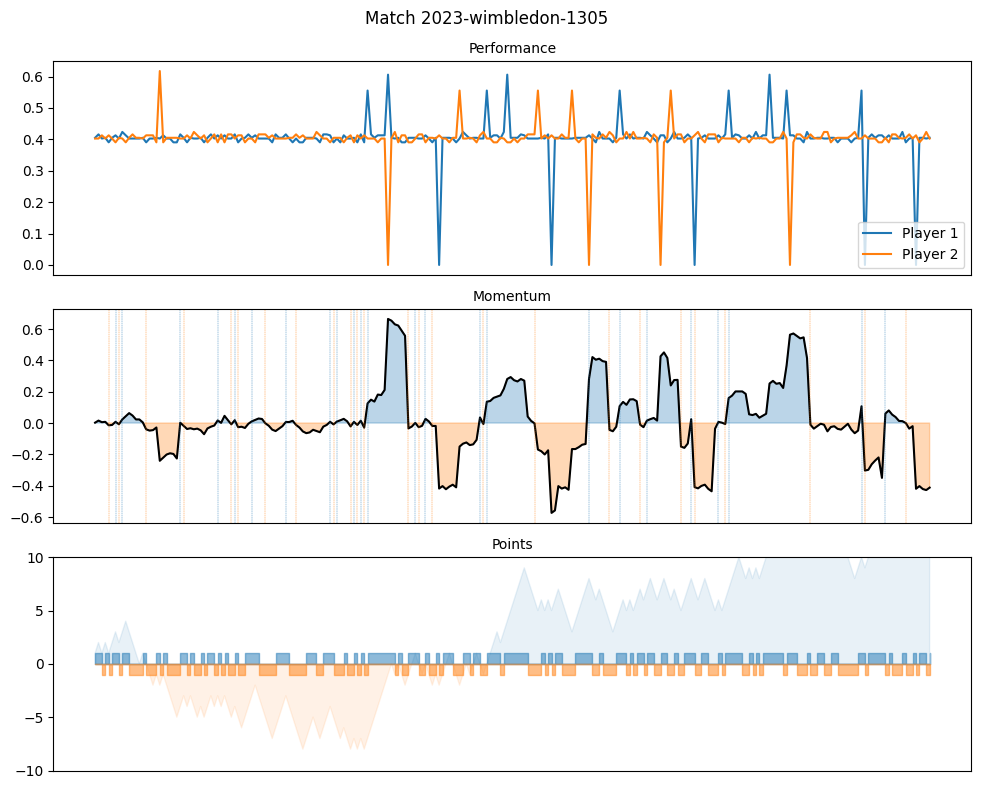

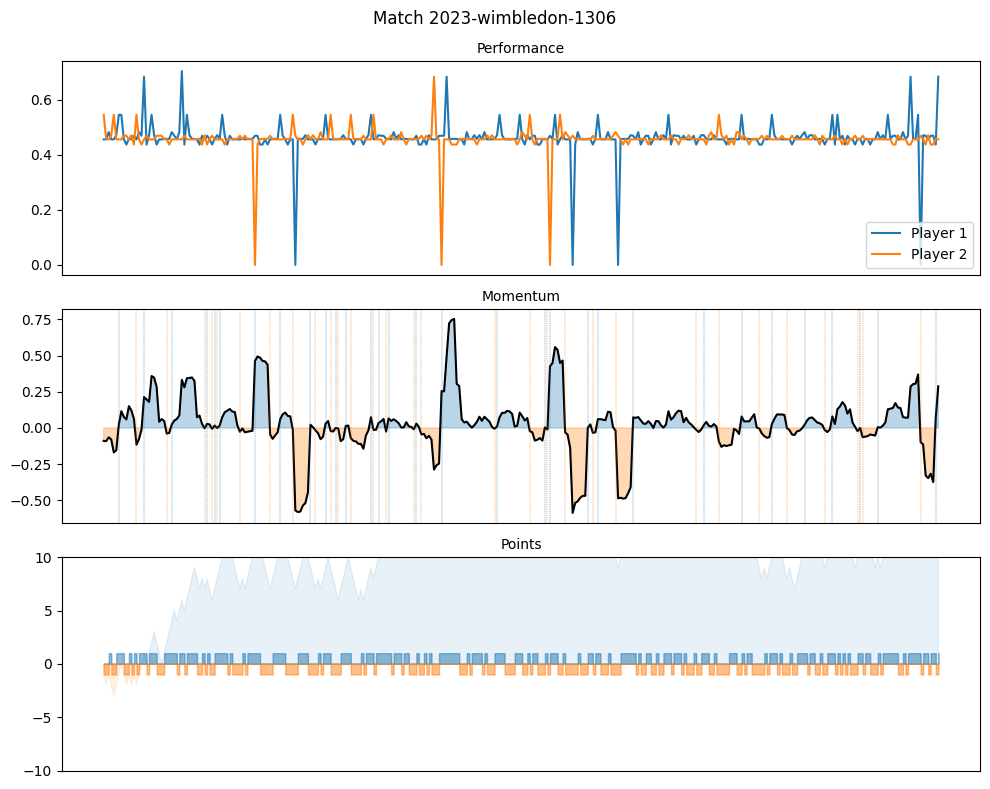

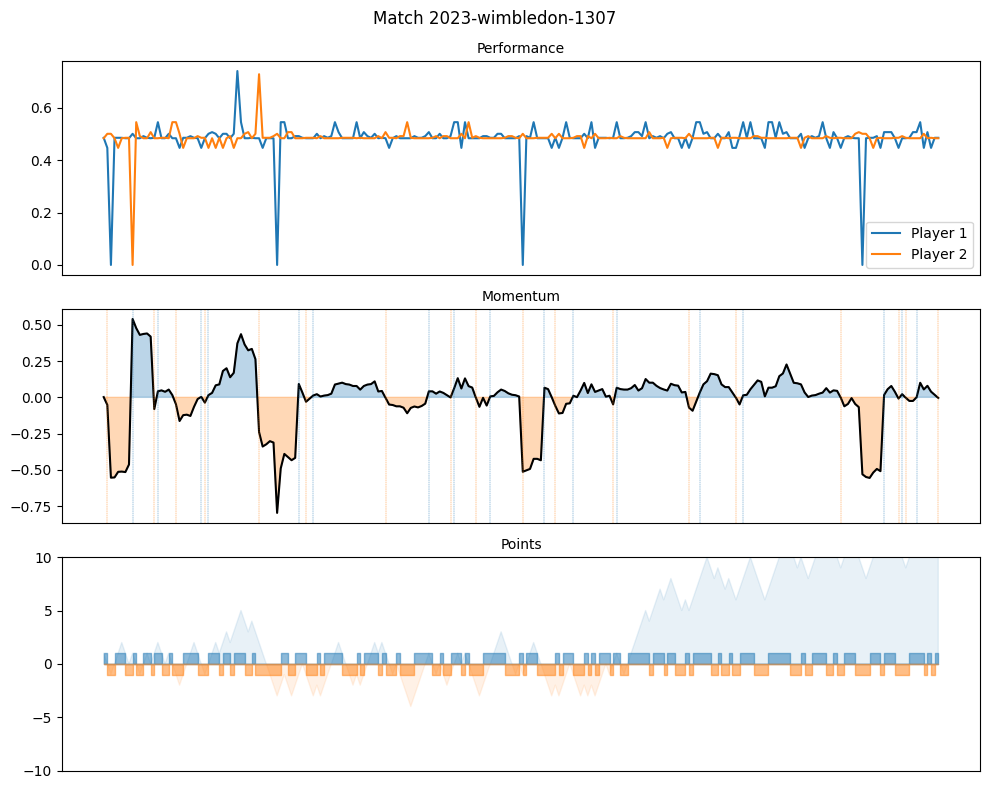

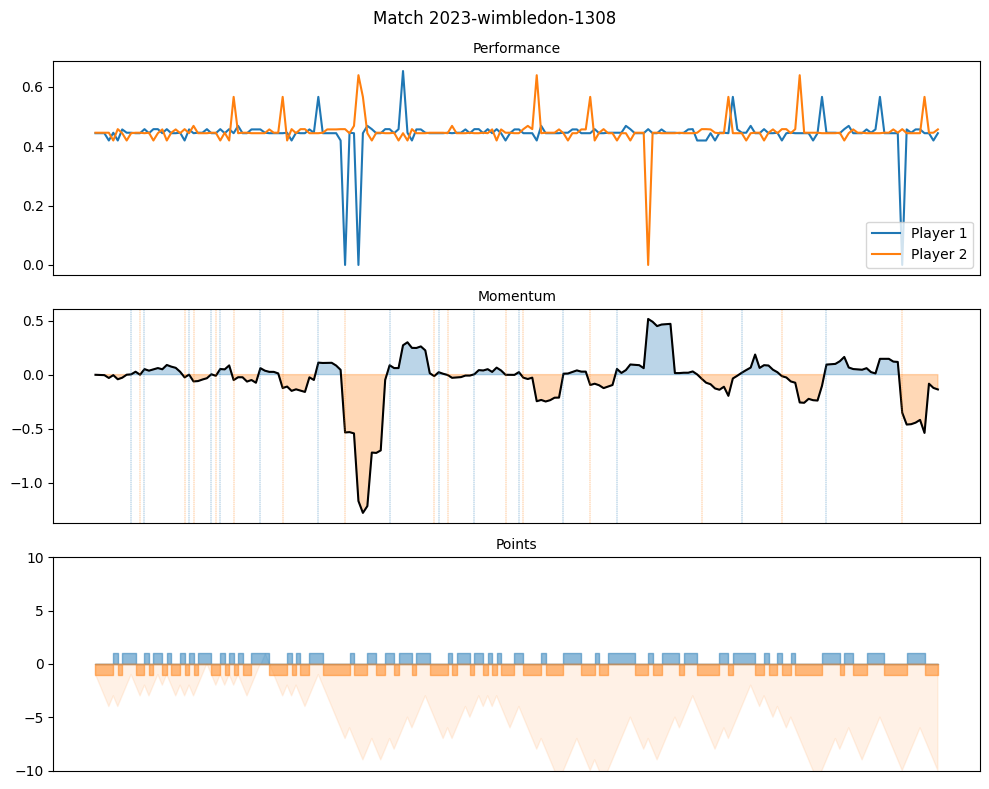

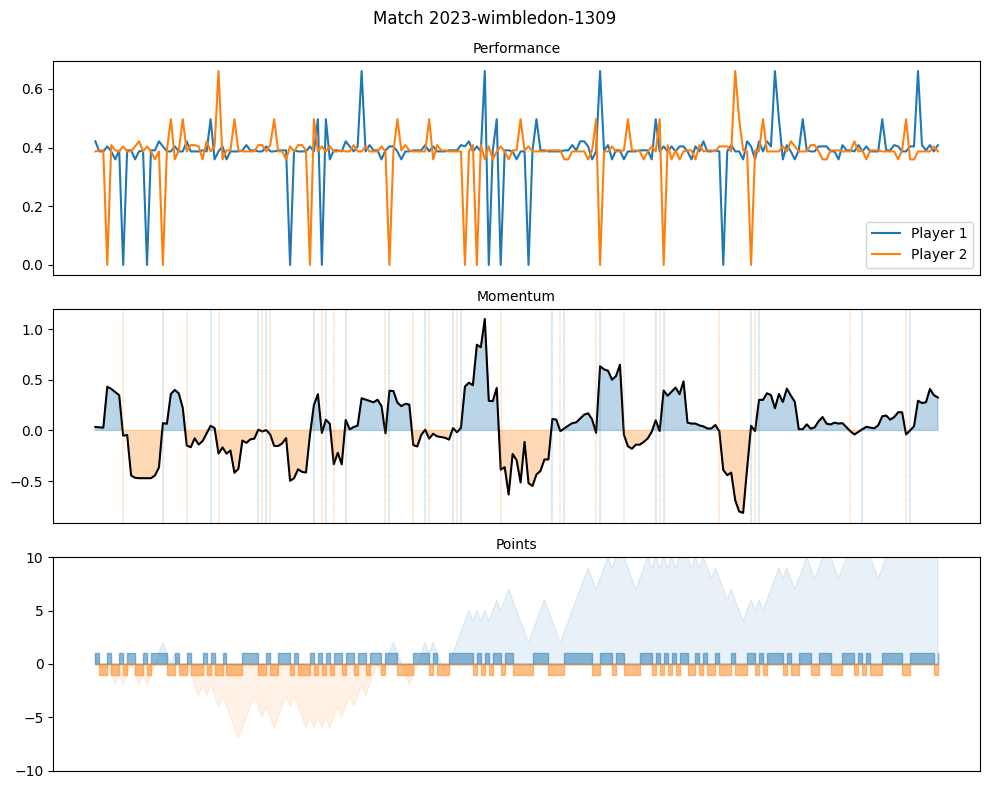

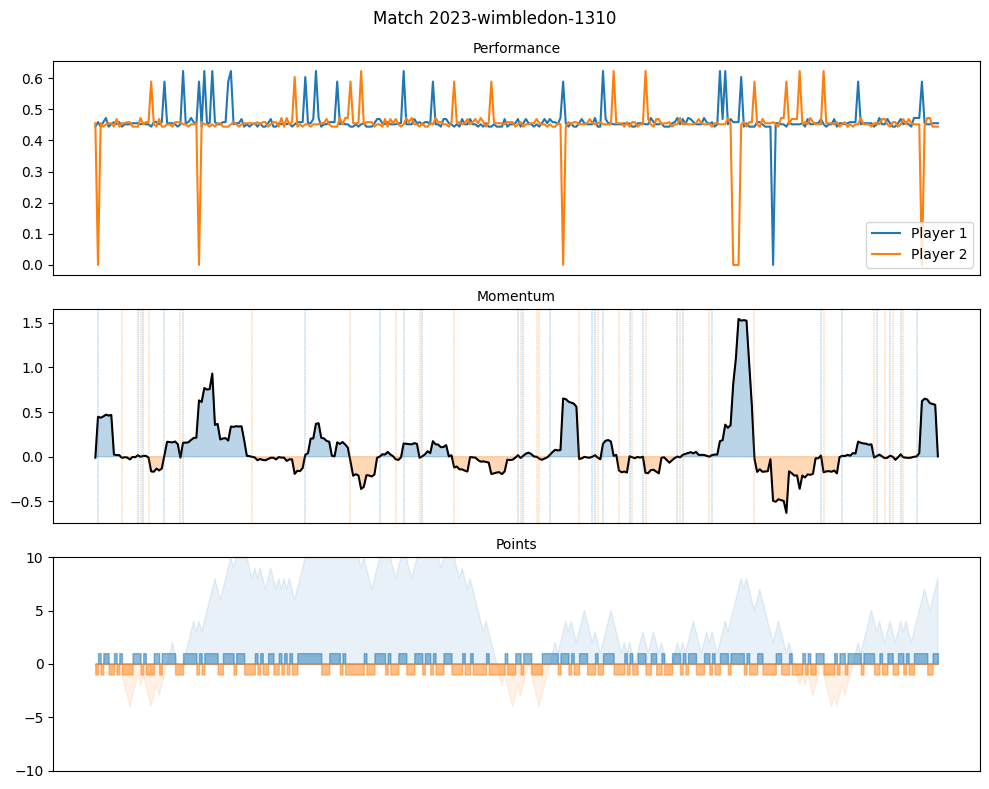

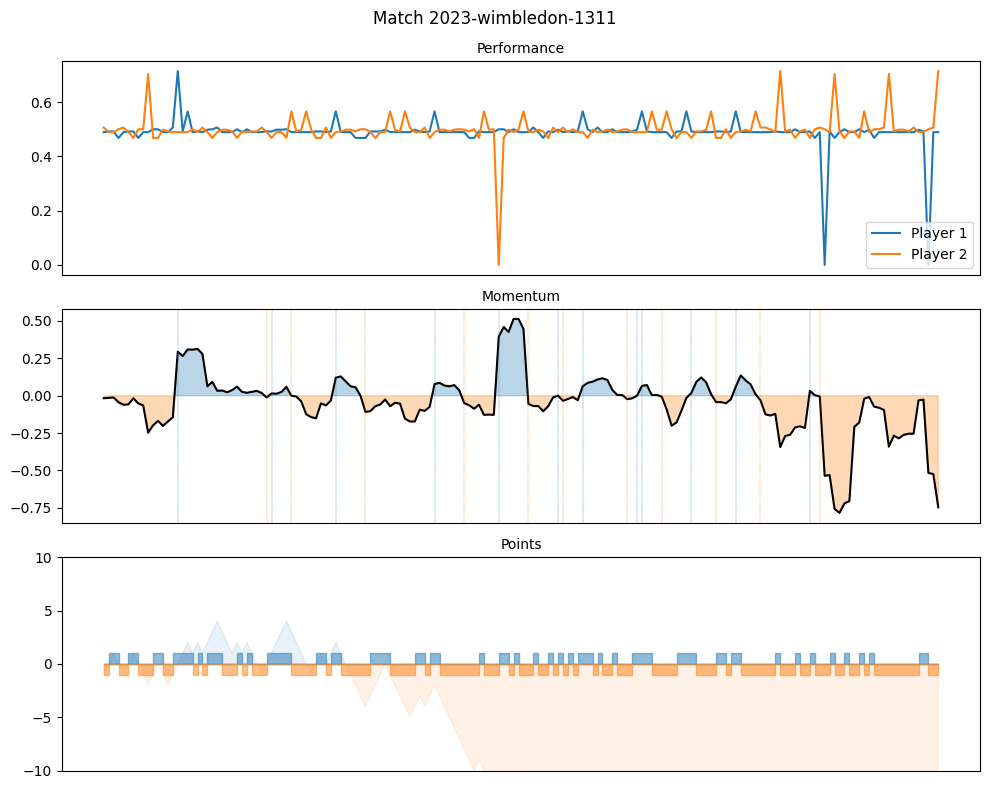

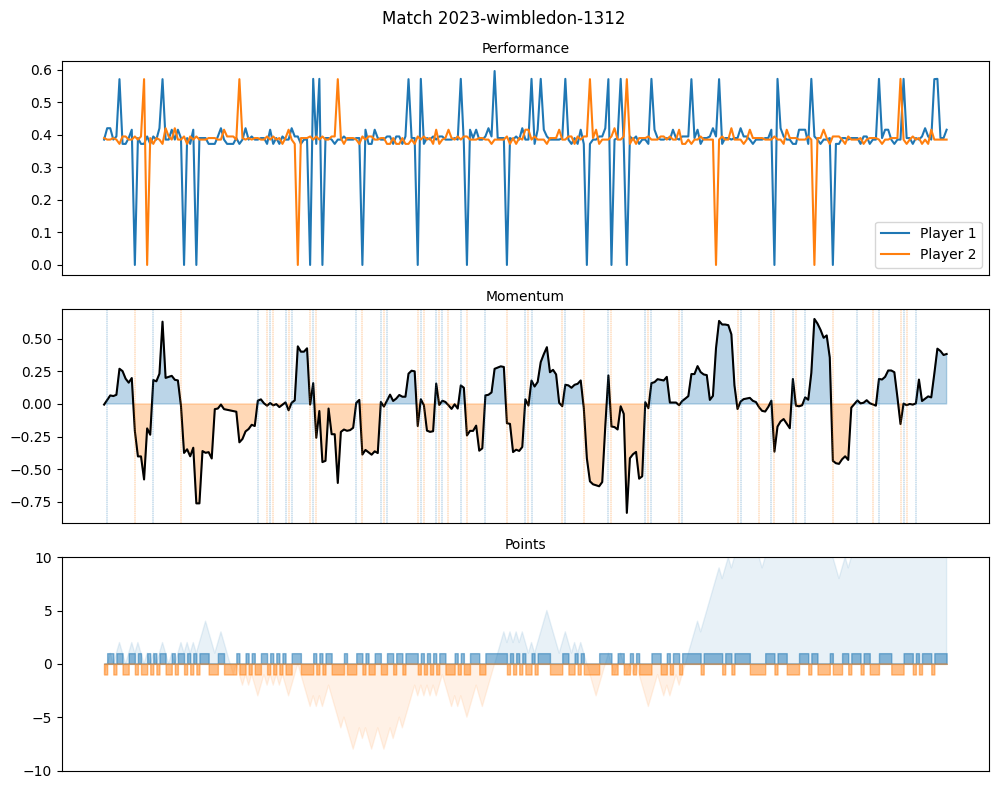

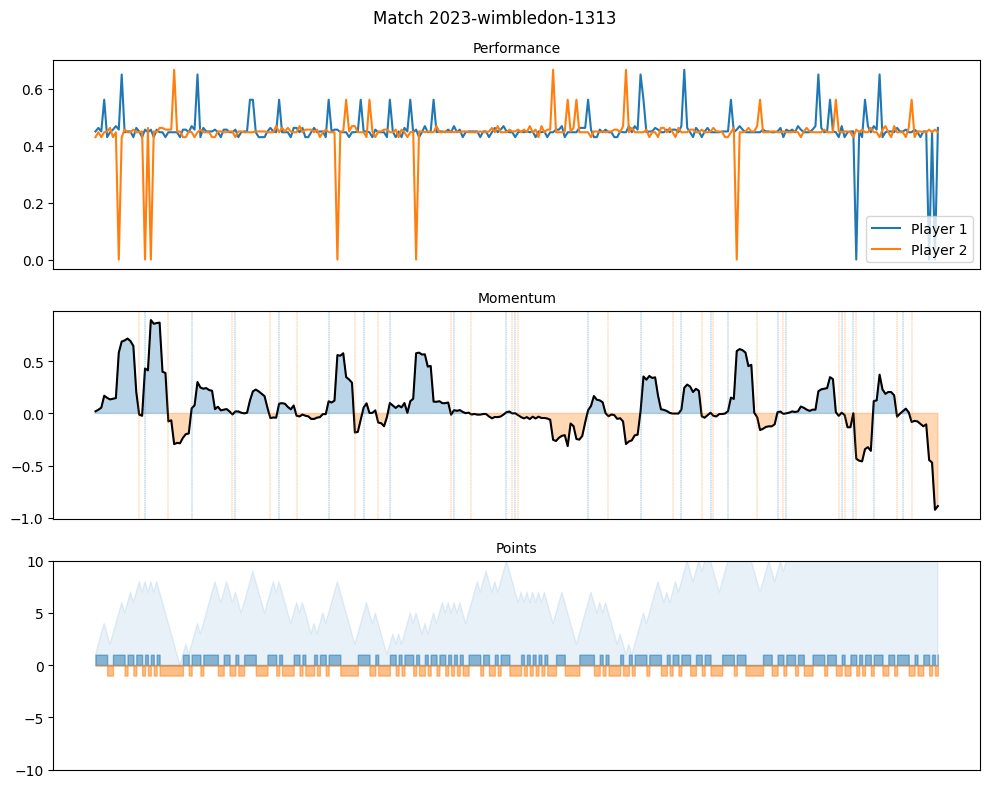

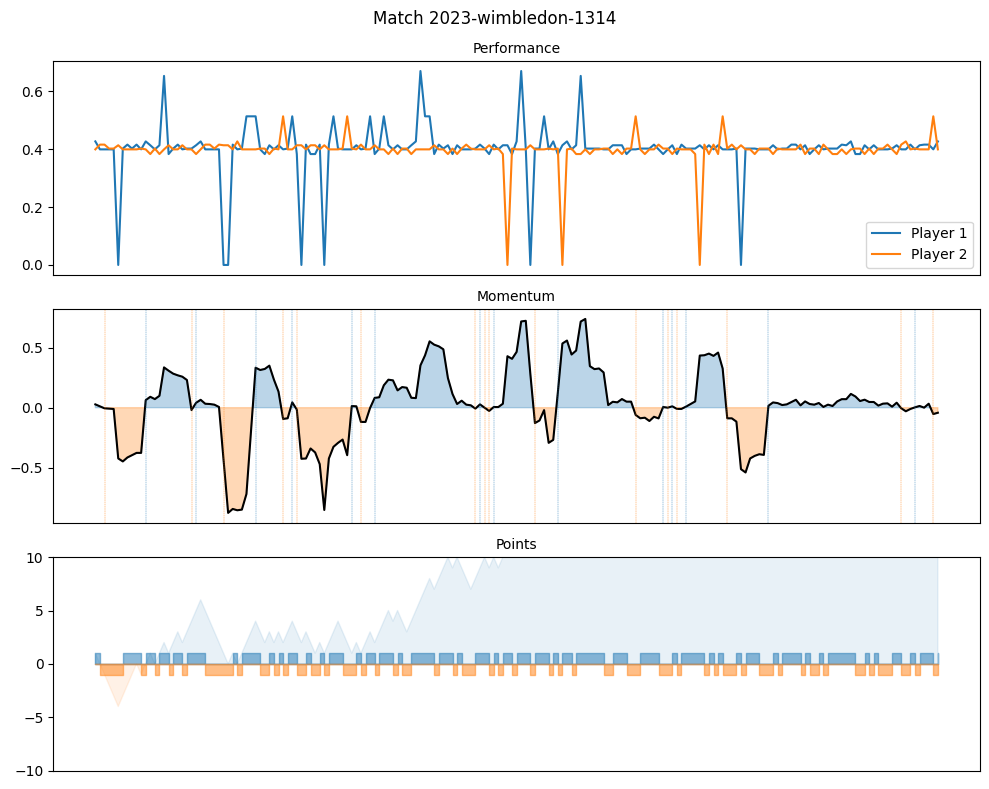

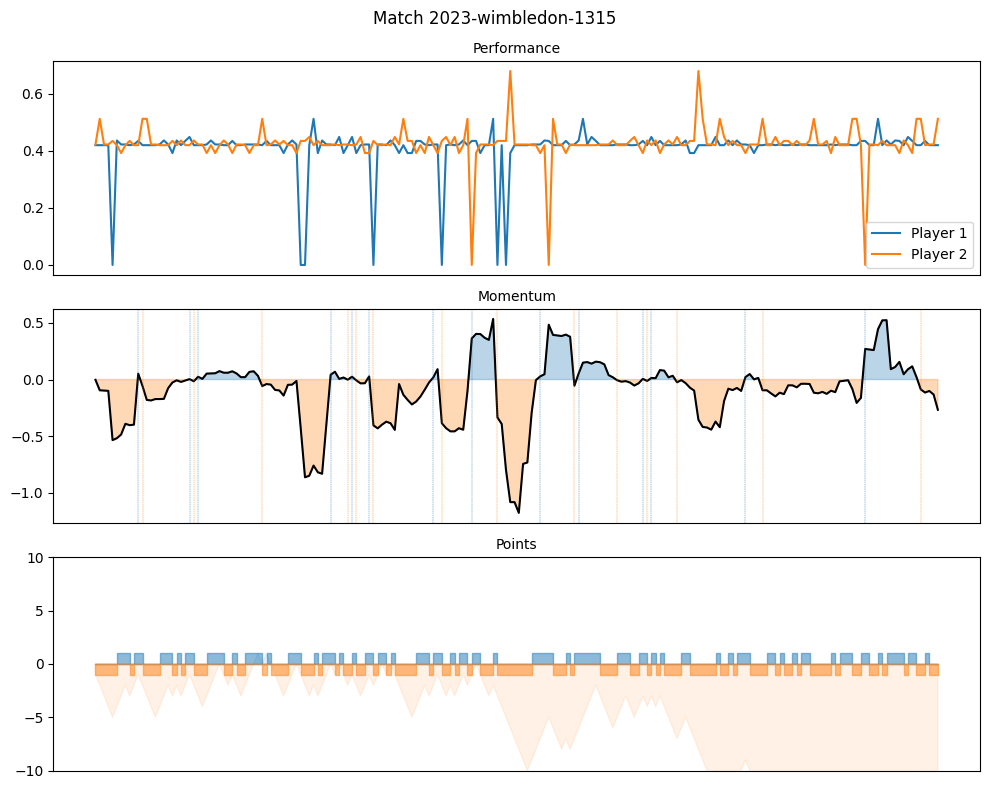

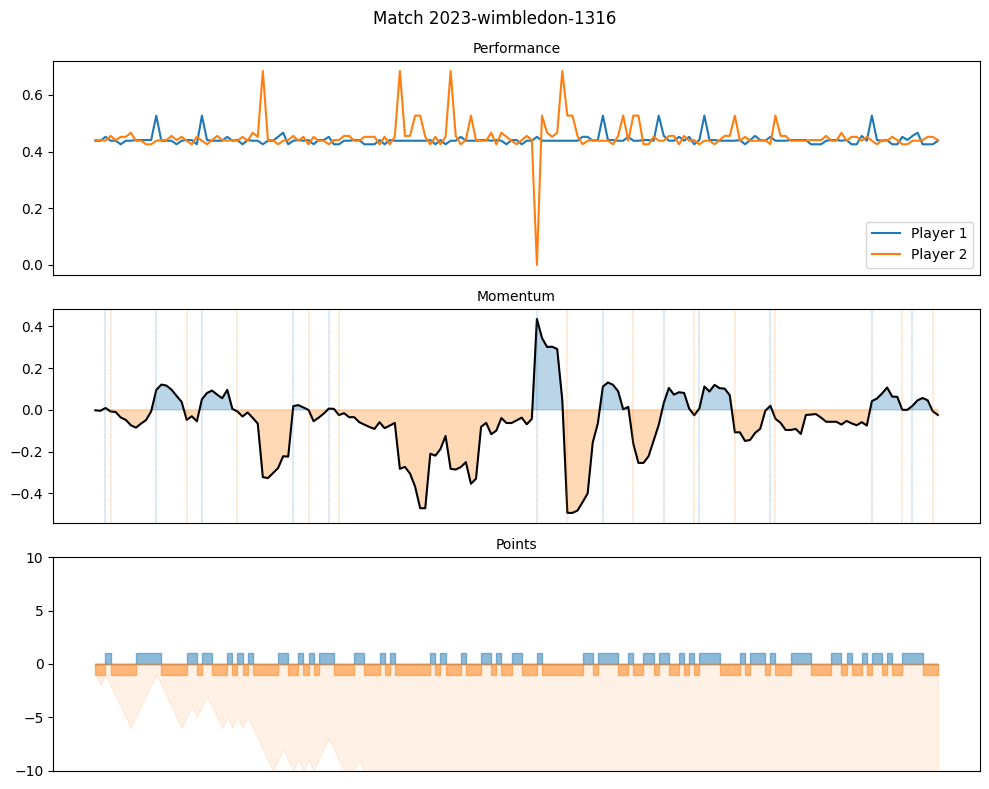

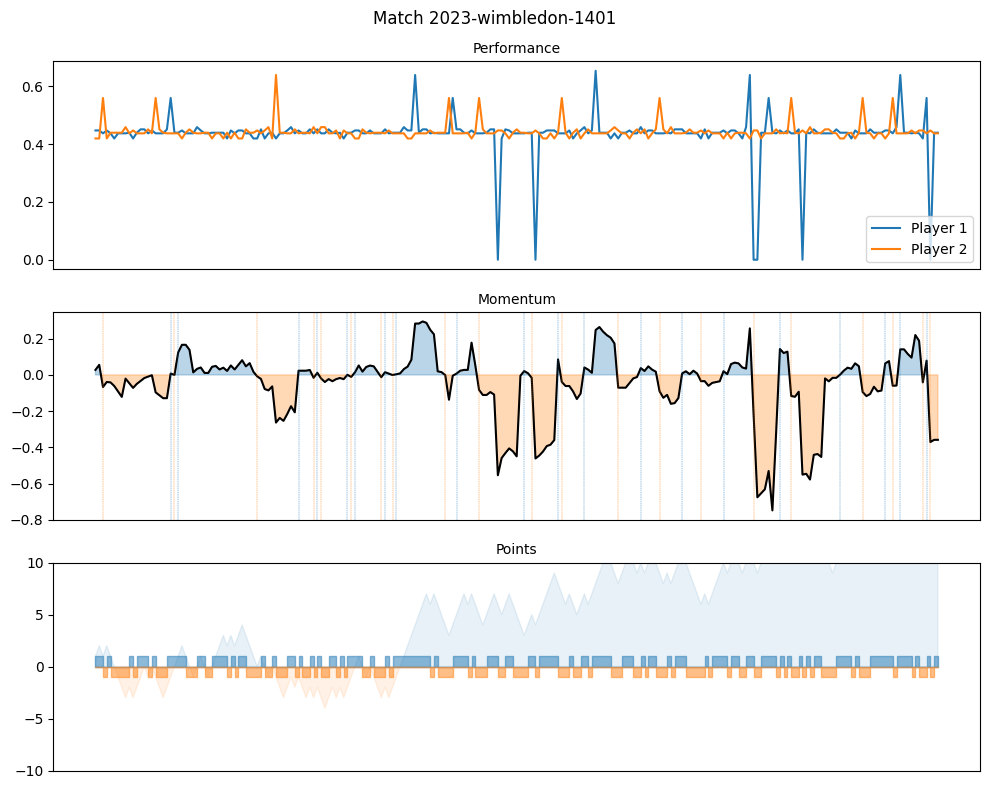

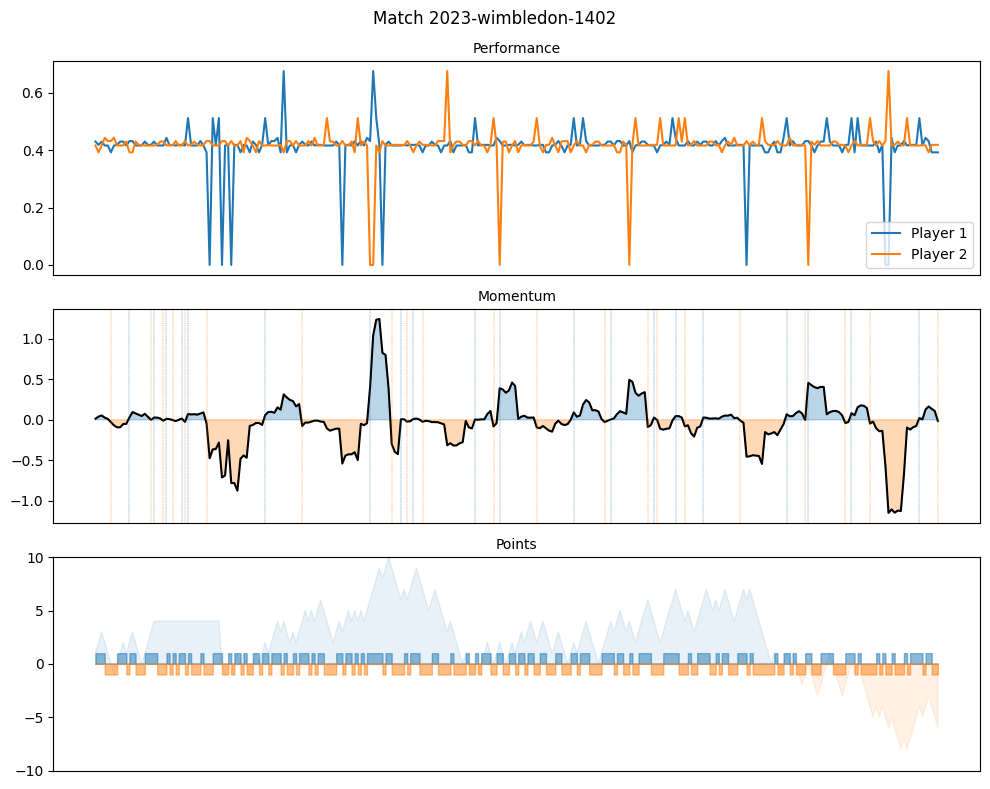

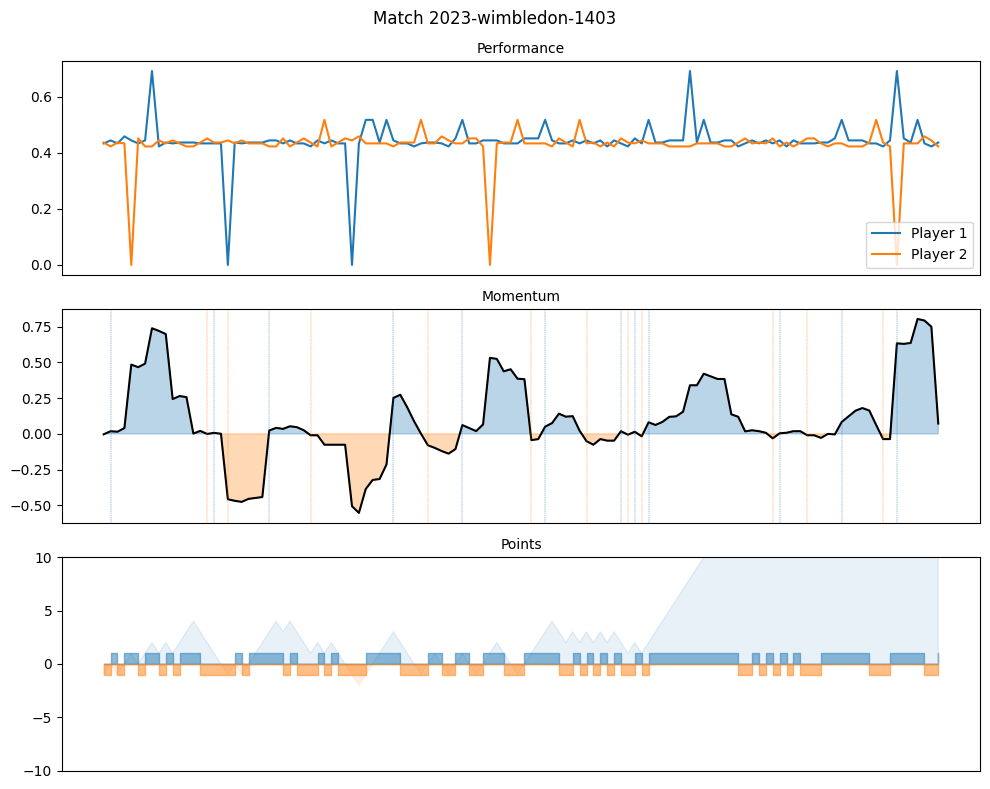

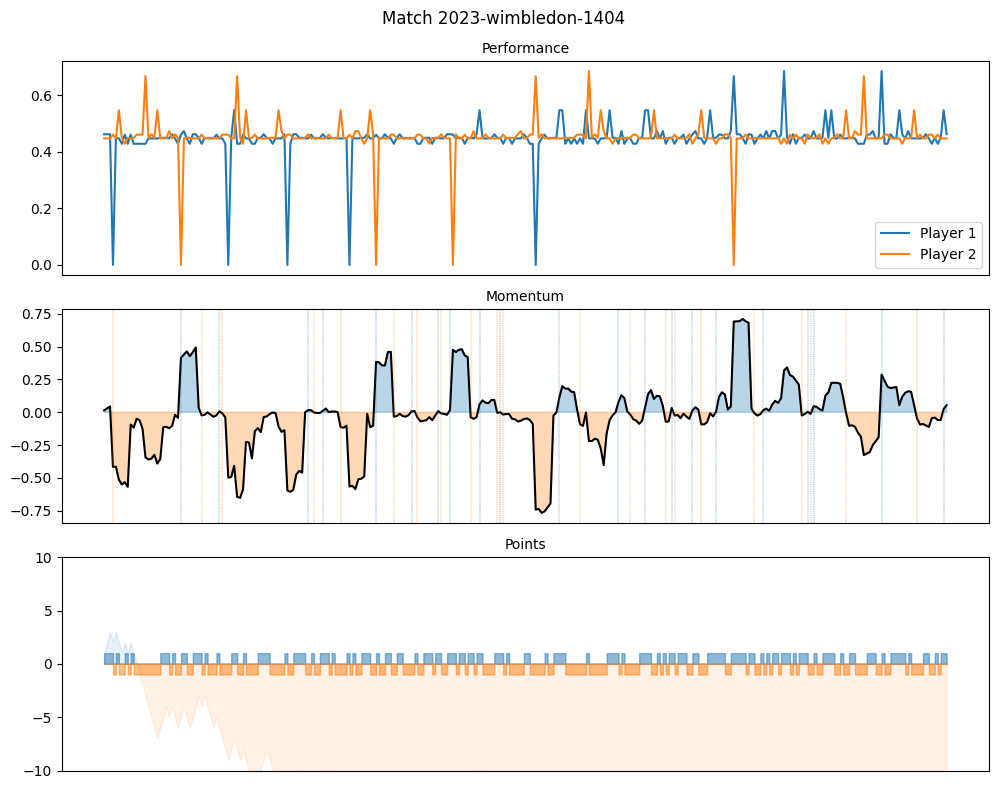

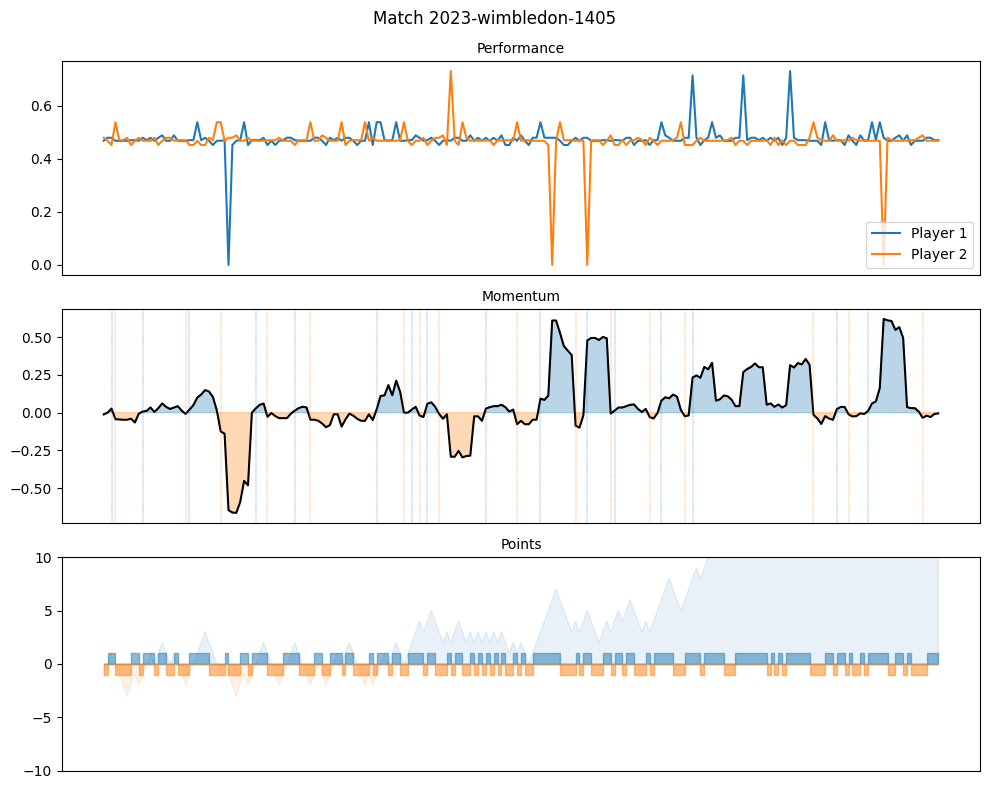

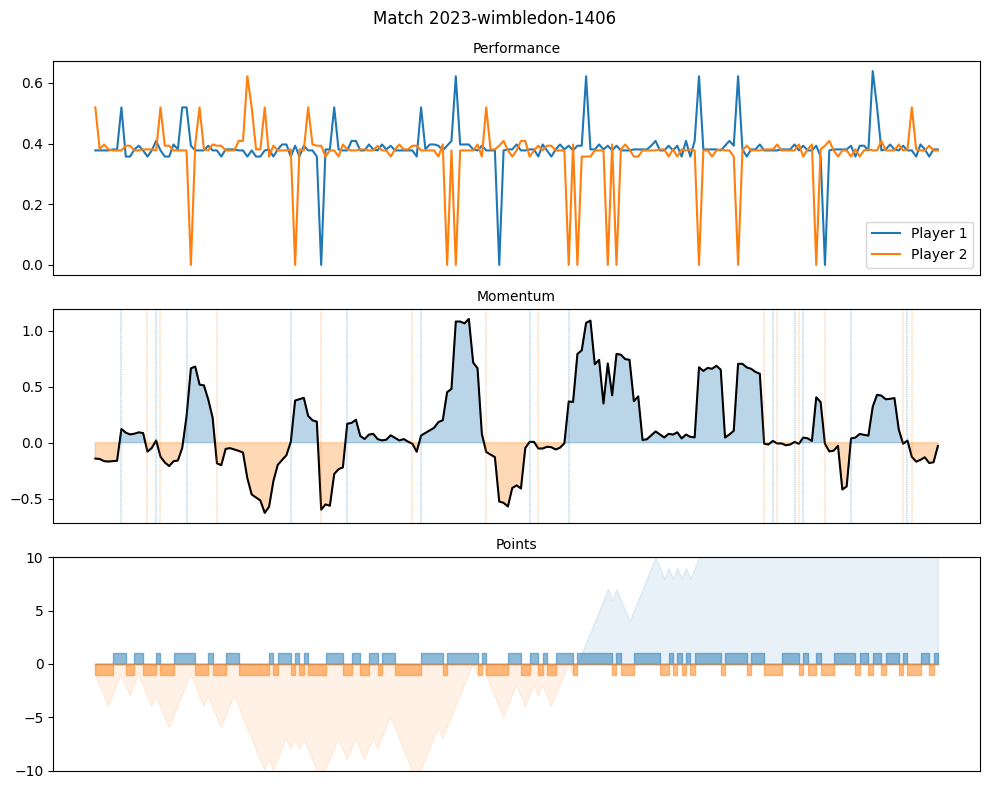

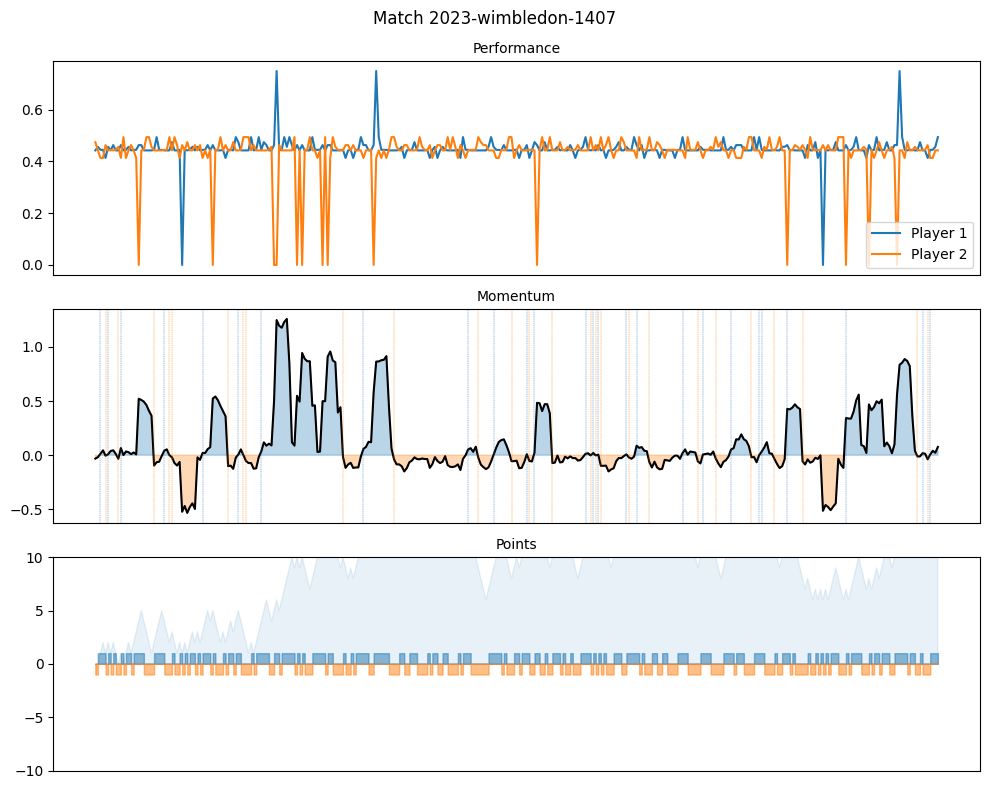

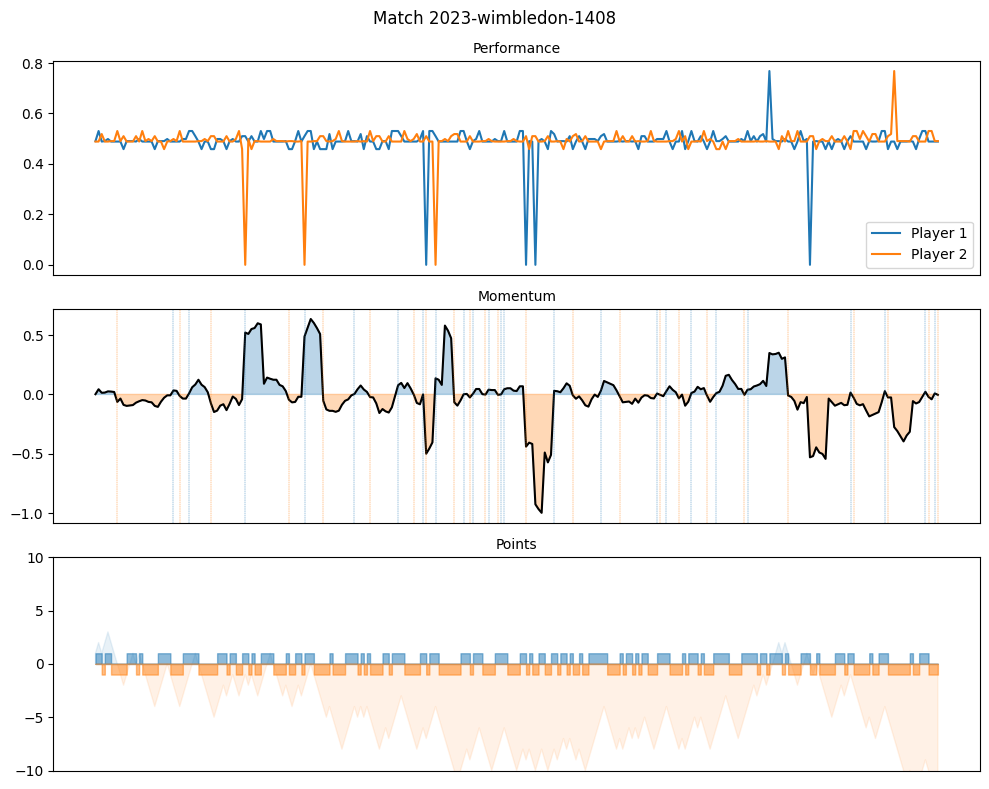

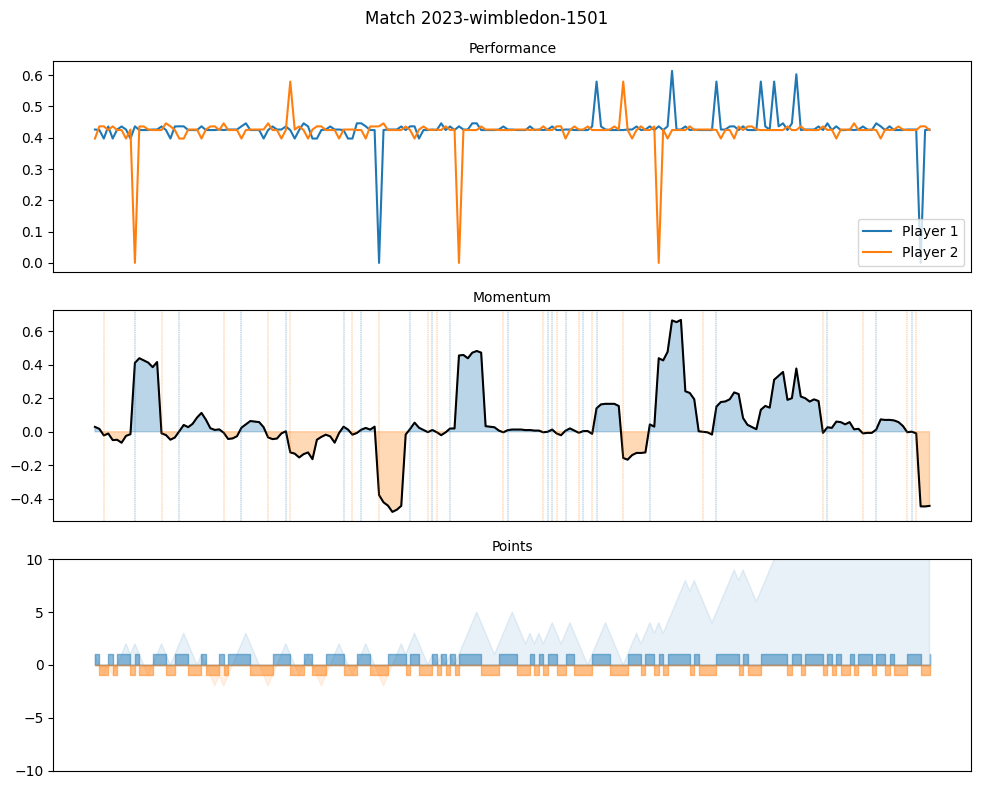

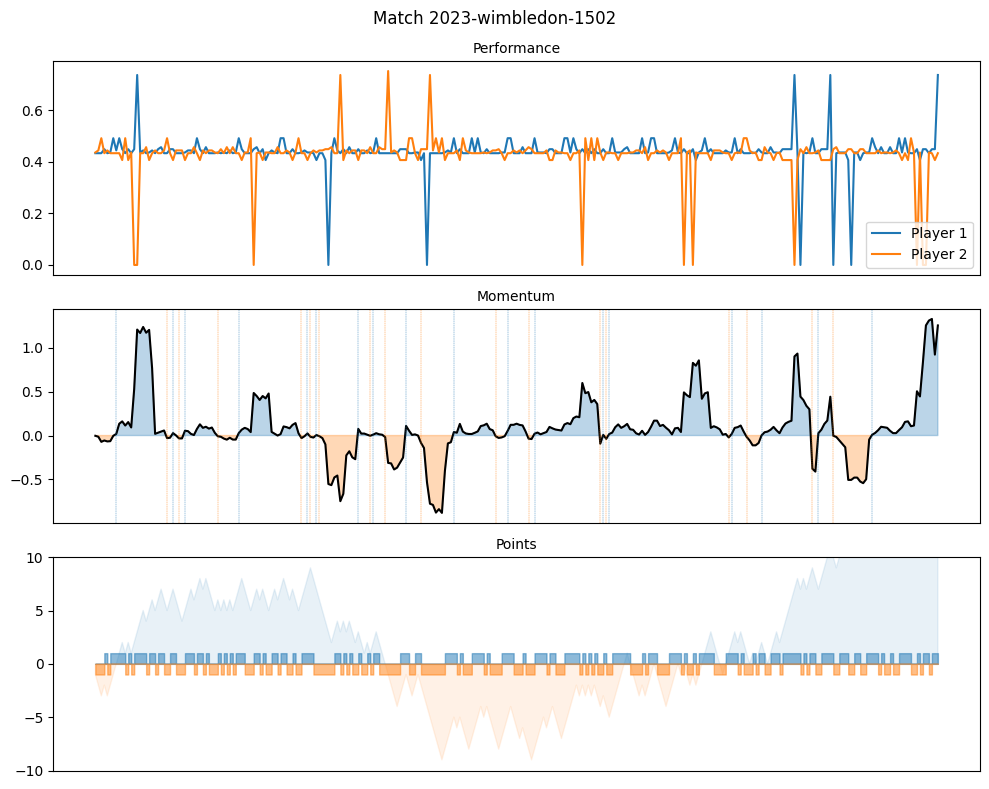

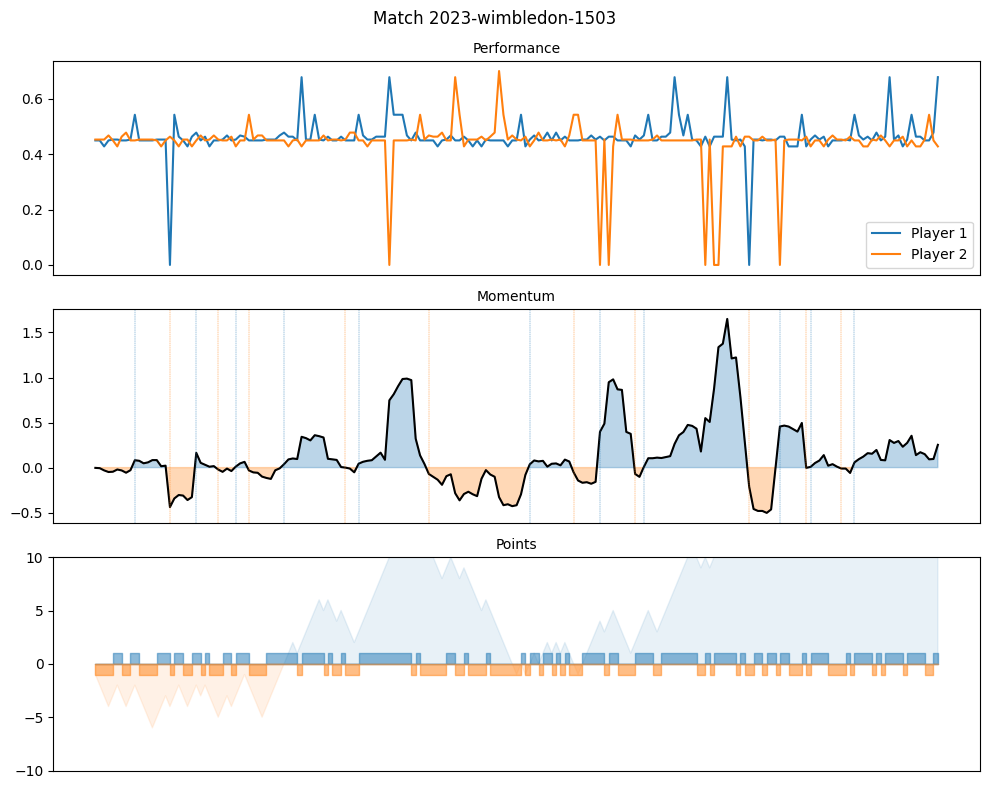

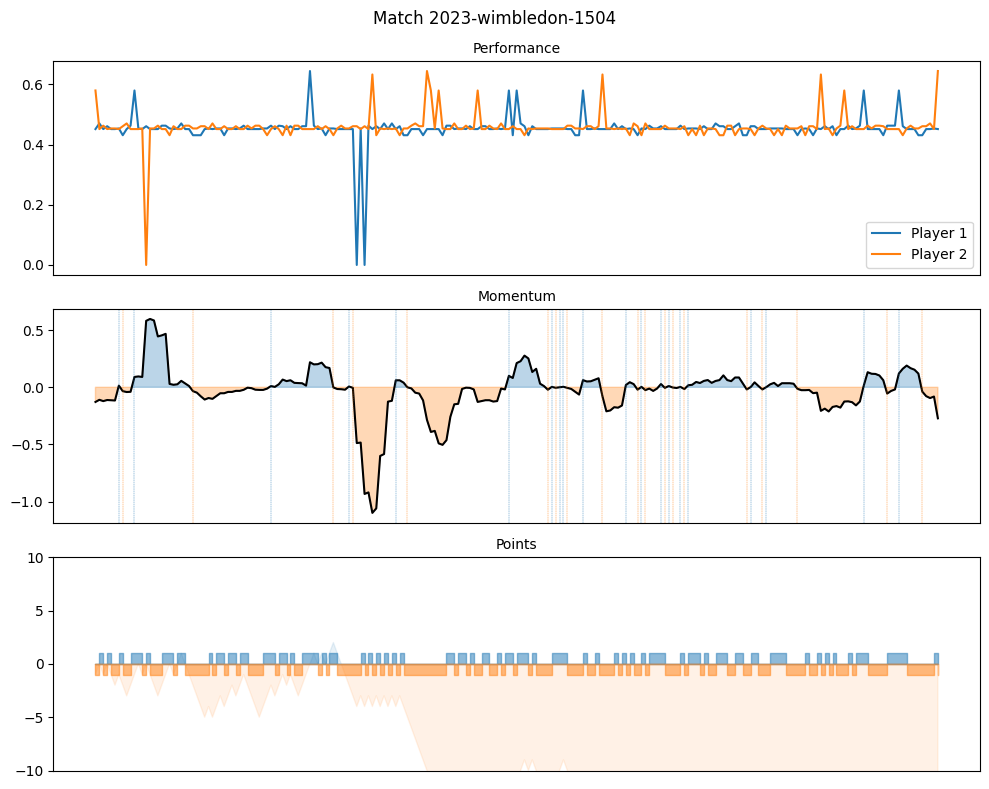

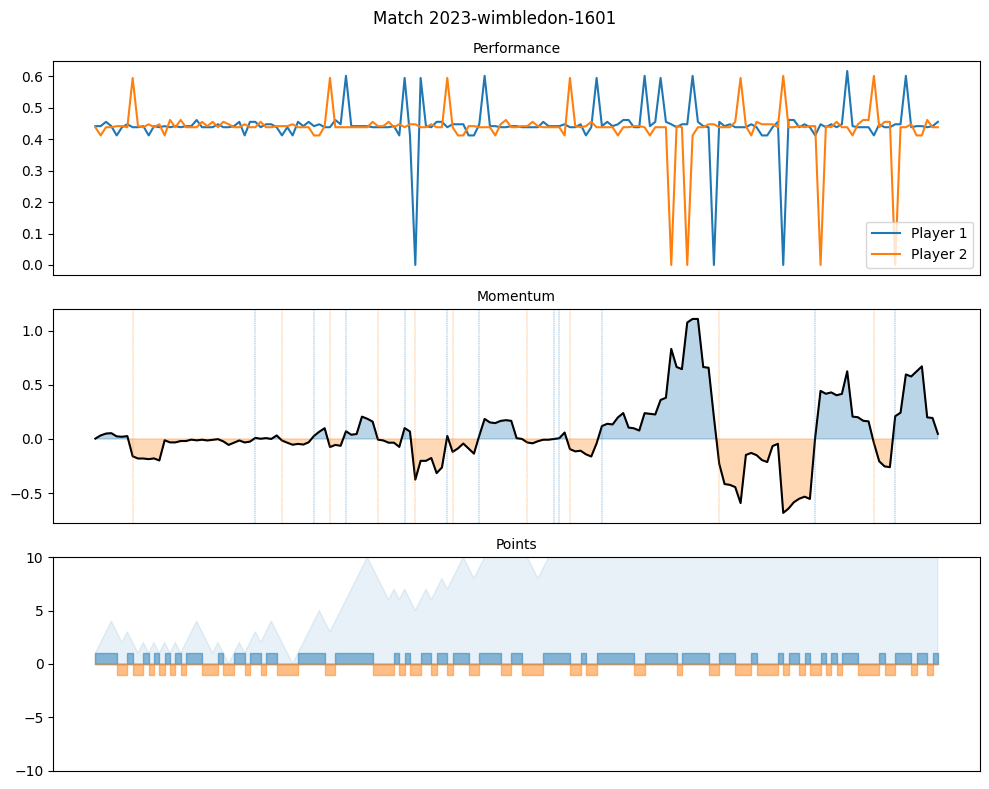

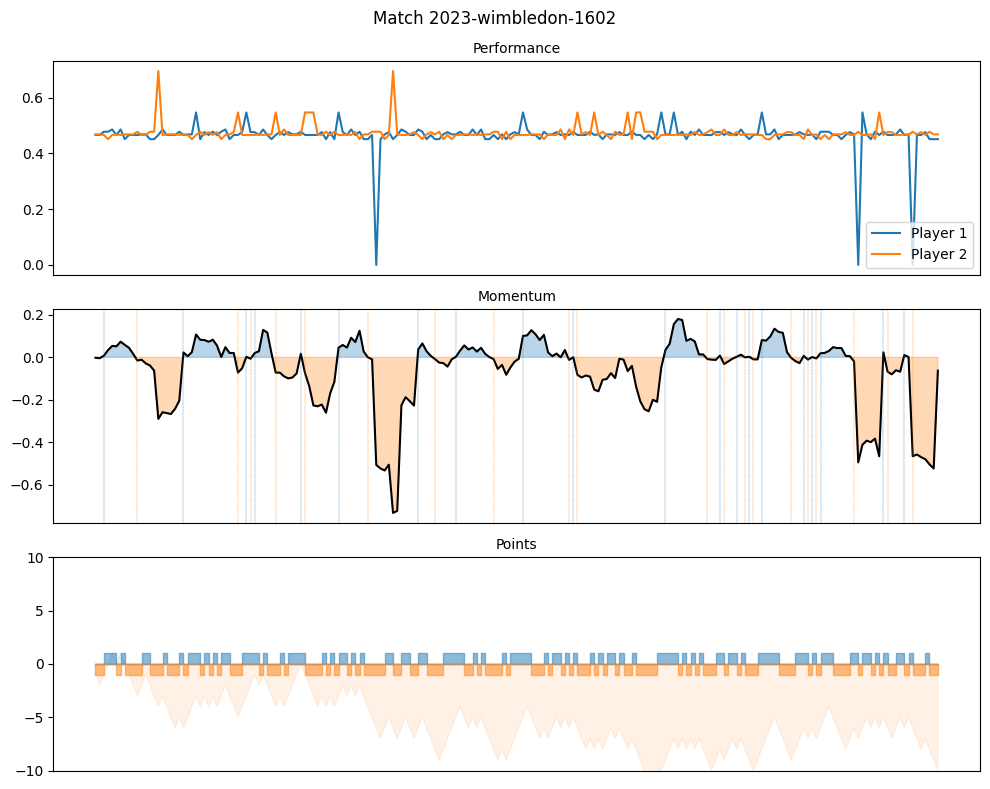

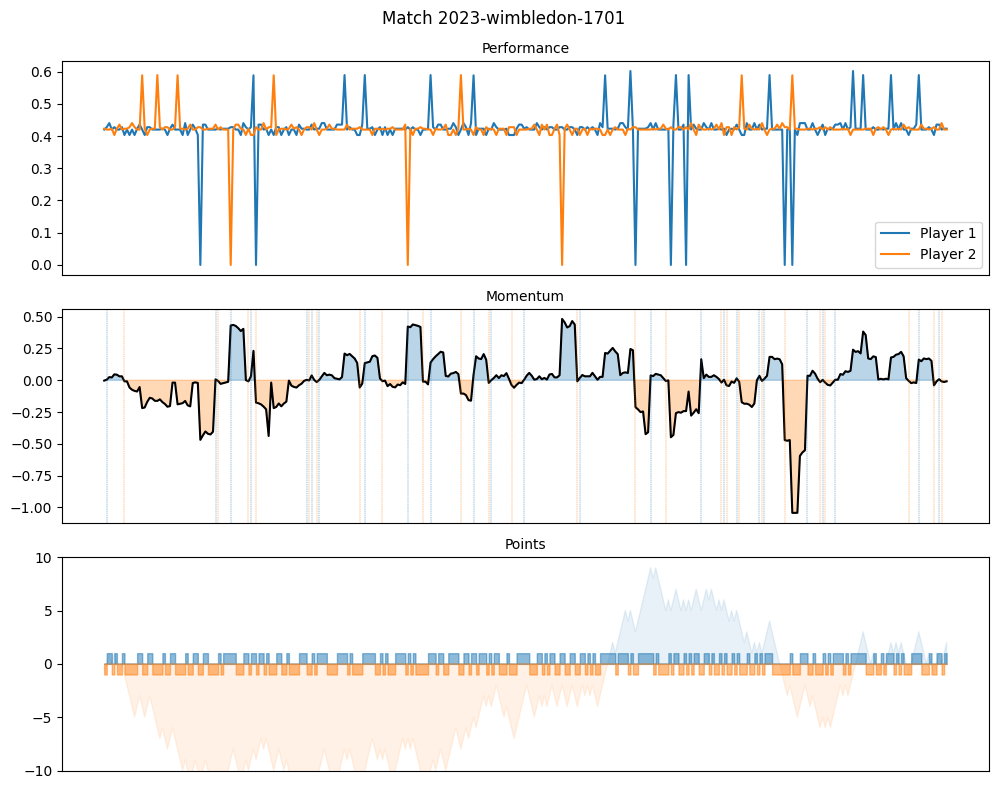

In [7]:
plot_match_info(df, n_samples=None, window_size=window_size, random_state=42)

## Feature Engineering

Record the swings in the data, with `0` meaning no swing, `-1` meaning a swing from being in favor of player 1 to being in favor of player 2, and `1` meaning a swing from being in favor of player 2 to being in favor of player 1.

In [8]:
df["swing"] = 0
for match_id in df["match_id"].unique():
    df_performance = get_performance(df, match_id)
    df_perf_diff = df_performance["p1"] - df_performance["p2"]
    ser_momentum = df_perf_diff.rolling(window_size).sum()
    ser_momentum = ser_momentum.fillna(df_perf_diff.cumsum())
    for i, sign_diff in (
        np.sign(ser_momentum).diff().where(lambda x: x != 0).dropna().items()
    ):
        df.loc[i, "swing"] = 1 if sign_diff > 0 else -1
df["swing"].value_counts()

swing
 0    6111
-1     587
 1     586
Name: count, dtype: int64

Extract information for player 1 and player 2 separately. For each player,

- `swing=0` means no swing, `swing=1` means the player changes from not being favored to being favored, and `swing=-1` means the converse.
- `is_server=1` means the player is the server, and `is_server=0` means the player is the receiver.
- `this_point=1` means the player wins the point, and `this_point=-1` means the player loses the point.
- `this_game=1` means the player wins the game, `this_game=0` means the game has not ended yet, and `this_game=-1` means the player loses the game.
- `this_set=1` means the player wins the set, `this_set=0` means the set has not ended yet, and `this_set=-1` means the player loses the set.

In [9]:
def this_transform(x, kind, primary):
    target = f"{kind}_victor"
    if x[target] == primary:
        return 1
    if x[target] == 0:
        return 0
    return -1

In [10]:
df_p1 = df.rename(columns=lambda x: x.replace("p1_", "")).rename(
    columns=lambda x: x.replace("p2_", "other_")
)
df_p1["is_server"] = df_p1.apply(lambda x: x["server"] == 1, axis=1)
for kind in ["point", "game", "set"]:
    df_p1[f"this_{kind}"] = df_p1.apply(lambda x: this_transform(x, kind, 1), axis=1)
df_p2 = df.rename(columns=lambda x: x.replace("p2_", "")).rename(
    columns=lambda x: x.replace("p1_", "other_")
)
df_p2["is_server"] = df_p2.apply(lambda x: x["server"] == 2, axis=1)
for kind in ["point", "game", "set"]:
    df_p2[f"this_{kind}"] = df_p1.apply(lambda x: this_transform(x, kind, 2), axis=1)
df_p2["swing"] = -df_p2["swing"]  # Invert the swing column
df_info = pd.concat([df_p1, df_p2], keys=["p1", "p2"])
# df_info["swing"] = df_info.groupby("match_id")["swing"].shift(1).fillna(0)
df_info.columns

Index(['match_id', 'player1', 'player2', 'elapsed_time', 'set_no', 'game_no',
       'point_no', 'sets', 'other_sets', 'games', 'other_games', 'score',
       'other_score', 'server', 'serve_no', 'point_victor', 'points_won',
       'other_points_won', 'game_victor', 'set_victor', 'ace', 'other_ace',
       'winner', 'other_winner', 'winner_shot_type', 'double_fault',
       'other_double_fault', 'unf_err', 'other_unf_err', 'net_pt',
       'other_net_pt', 'net_pt_won', 'other_net_pt_won', 'break_pt',
       'other_break_pt', 'break_pt_won', 'other_break_pt_won',
       'break_pt_missed', 'other_break_pt_missed', 'distance_run',
       'other_distance_run', 'rally_count', 'speed_mph', 'serve_width',
       'serve_depth', 'return_depth', 'swing', 'is_server', 'this_point',
       'this_game', 'this_set'],
      dtype='object')

About the scores: there should be 0 (love), 15 (first point won), 30 (second point won), and 40 (third point won). When the score is 40-40, it is called "deuce". When a player has advantage, it is called AD. When a player wins the game, the score is reset to 0-0. We make this into the following features:

- `feat_score`: the score of the player. 0 maps to 0, 15 maps to 1, 30 maps to 2, 40 maps to 3, and AD maps to 4.
- `feat_score_diff`: the difference in scores (player - opponent).
- `feat_deuce_ad`: 1 if advantage in deuce, -1 if opponent has advantage in deuce, and 0 otherwise.
- `feat_point_count`: the number of points passed in the current game.

In [11]:
valid_vals = ["0", "15", "30", "40", "AD"]
valid_mask = df_info["score"].isin(valid_vals) & df_info["other_score"].isin(valid_vals)
print(f"{len(df_info) - valid_mask.sum()} invalid out of {len(df_info)}")
df_info = df_info[valid_mask]

688 invalid out of 14568


In [12]:
mapping = {"0": 0, "15": 1, "30": 2, "40": 3, "AD": 4}
df_info["feat_score"] = df_info["score"].map(mapping)
df_info["feat_score_diff"] = df_info["feat_score"] - df_info["other_score"].map(mapping)
df_info["feat_deuce_ad"] = 0
for i in df_info.index:
    if df_info.loc[i, "score"] == "AD":
        df_info.at[i, "feat_deuce_ad"] = 1
    elif df_info.loc[i, "other_score"] == "AD":
        df_info.at[i, "feat_deuce_ad"] = -1
df_info["feat_point_count"] = (
    df_info.groupby(
        (df_info["game_no"] != df_info["game_no"].shift(1)).cumsum()
    ).cumcount()
    + 1
)

- `feat_game_diff`: the difference in games won (player - opponent).
- `feat_set_diff`: the difference in sets won (player - opponent).

In [13]:
df_info["feat_game_diff"] = df_info["games"] - df_info["other_games"]
df_info["feat_set_diff"] = df_info["sets"] - df_info["other_sets"]

- `feat_cont_victors`: my contiguous victors in a row.
- `feat_cont_losers`: my contiguous losers in a row.

In [14]:
df_info["feat_cont_victors"] = (
    (df_info["this_point"] == 1)
    .groupby((df_info["this_point"] != df_info["this_point"].shift()).cumsum())
    .cumsum()
)
df_info["feat_cont_losers"] = (
    (df_info["this_point"] == -1)
    .groupby((df_info["this_point"] != df_info["this_point"].shift()).cumsum())
    .cumsum()
)

- `feat_unf_err`: unforced error by the player for the current point.
- `feat_unf_errs_game`: the number of unforced errors by the player in the current game.
- `feat_unf_errs_set`: the number of unforced errors by the player in the current set.
- `feat_unf_err_oppn`: unforced error by the opponent for the current point.
- `feat_double_fault`: double fault by the player for the current point.
- `feat_double_faults_game`: the number of double faults by the player in the current game.
- `feat_double_faults_set`: the number of double faults by the player in the current set.
- `feat_double_fault_oppn`: double fault by the opponent for the current point.

In [15]:
df_info["feat_unf_err"] = df_info["unf_err"]
df_info["feat_unf_errs_game"] = df_info.groupby(["match_id", "set_no", "game_no"])[
    "unf_err"
].cumsum()
df_info["feat_unf_errs_set"] = df_info.groupby(["match_id", "set_no"])[
    "unf_err"
].cumsum()
df_info["feat_unf_err_oppn"] = df_info["other_unf_err"]
df_info["feat_double_fault"] = df_info["double_fault"]
df_info["feat_double_faults_game"] = df_info.groupby(["match_id", "set_no", "game_no"])[
    "double_fault"
].cumsum()
df_info["feat_double_faults_set"] = df_info.groupby(["match_id", "set_no"])[
    "double_fault"
].cumsum()
df_info["feat_double_fault_oppn"] = df_info["other_double_fault"]

- `feat_ace`: ace by the player for the current point.
- `feat_aces_game`: the number of aces by the player in the current game.
- `feat_aces_set`: the number of aces by the player in the current set.
- `feat_ace_oppn`: ace by the opponent for the current point.
- `feat_winner`: winner by the player for the current point.
- `feat_winners_game`: the number of winners by the player in the current game.
- `feat_winners_set`: the number of winners by the player in the current set.
- `feat_winner_oppn`: winner by the opponent for the current point.

In [16]:
df_info["feat_ace"] = df_info["ace"]
df_info["feat_aces_game"] = df_info.groupby(["match_id", "set_no", "game_no"])[
    "ace"
].cumsum()
df_info["feat_aces_set"] = df_info.groupby(["match_id", "set_no"])["ace"].cumsum()
df_info["feat_ace_oppn"] = df_info["other_ace"]
df_info["feat_winner"] = df_info["winner"]
df_info["feat_winners_game"] = df_info.groupby(["match_id", "set_no", "game_no"])[
    "winner"
].cumsum()
df_info["feat_winners_set"] = df_info.groupby(["match_id", "set_no"])["winner"].cumsum()
df_info["feat_winner_oppn"] = df_info["other_winner"]

- `feat_break_pt_missed`: the player missed an opportunity to win a game the opponent served.
- `feat_break_pt_won`: the player won the game the opponent served.
- `feat_break_pt_oppn_missed`: the opponent missed an opportunity to win a game the player served.
- `feat_break_pt_oppn_won`: the opponent won the game the player served.

In [17]:
df_info["feat_break_pt_missed"] = df_info["break_pt_missed"]
df_info["feat_break_pt_won"] = df_info["break_pt_won"]
df_info["feat_break_pt_oppn_missed"] = df_info["other_break_pt_missed"]
df_info["feat_break_pt_oppn_won"] = df_info["other_break_pt_won"]

- `feat_speed_mph`: the speed of the serve, 0 if the player is not serving.
- `feat_speed_mph_oppn`: the speed of the serve, 0 if the player is serving.

In [18]:
df_info["feat_speed_mph"] = df_info["speed_mph"] * df_info["is_server"].map(
    {True: 1, False: 0}
)
df_info["feat_speed_mph_oppn"] = df_info["speed_mph"] * df_info["is_server"].map(
    {True: 0, False: 1}
)

- `feat_distance_run`: distance ran by the player in the current point.
- `feat_distance_run_game`: distance ran by the player in the current game.

In [19]:
df_info["feat_distance_run"] = df_info["distance_run"]
df_info["feat_distance_run_game"] = df_info.groupby(["match_id", "set_no", "game_no"])[
    "distance_run"
].cumsum()

- `feat_net_pt`: whether the player is at the net in the current point.
- `feat_net_pt_won`: whether the player won the point at the net.

In [20]:
df_info["feat_net_pt"] = df_info["net_pt"]
df_info["feat_net_pt_won"] = df_info["net_pt_won"]

- `feat_is_server`: 1 if the player is the server, 0 otherwise.
- `feat_rally_count`: number of shots in the current point.

In [21]:
df_info["feat_is_server"] = df_info["is_server"].astype(int)
df_info["feat_rally_count"] = df_info["rally_count"]

- `feat_time`: the time of the current point.

In [22]:
df_info["elapsed_time_td"] = pd.to_timedelta(df_info["elapsed_time"])
df_info["feat_time"] = (
    df_info.groupby("match_id")["elapsed_time_td"].diff().dt.total_seconds()
)
df_info["feat_time"] = df_info["feat_time"].fillna(0)

Filter out our candidate features and limit to only one player (because the two players are symmetric that may cause some issues).

In [23]:
df_info["swing"] = df_info["swing"].where(df_info["swing"] == 0, 1)
df_info = df_info[df_info.index.get_level_values(0) == "p1"]
df_info = df_info.filter(regex="^feat|^swing$")
df_info = df_info.rename(columns=lambda x: x.replace("feat_", ""))

Eliminate missing values.

In [24]:
for feat in df_info.columns:
    nan_count = df_info[feat].isna().sum()
    if nan_count > 0:
        print(f"{feat} has {nan_count} missing values")
df_info[:] = SimpleImputer(strategy="most_frequent").fit_transform(df_info)
assert not df_info.isna().any().any()

speed_mph has 716 missing values
speed_mph_oppn has 716 missing values


Define a function for plotting correlation coefficient and p-value.

In [25]:
def plot_correlation(df_info, *, method, scipy_func, description, storage):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7), sharey=True)

    # Correlation coefficient
    correlation = df_info.corr(method=method)["swing"].drop("swing", axis=0).sort_values()
    bars = ax1.barh(correlation.index, correlation)
    ax1.bar_label(bars, fmt="%.3f", padding=5, fontsize=8)
    xlim = ax1.get_xlim()
    ax1.set_xlim(xlim[0] - 0.01, xlim[1] + 0.01)
    ax1.set_title("Coefficient")
    ax1.tick_params(axis="both", labelsize=8)

    # P-value
    correlation_p = (
        df_info.corr(lambda x, y: scipy_func(x, y).pvalue)["swing"]
        .drop("swing", axis=0)
        .sort_values(ascending=False)
    )
    p_bars = ax2.barh(correlation_p.index, correlation_p, color="lightgrey")
    ax2.bar_label(p_bars, fmt="%.1e", padding=5, fontsize=8)
    ax2.axvline(0.05, color="red", linestyle="--", lw=1)
    xlim = ax2.get_xlim()
    ax2.set_xlim(0, xlim[1] + 0.1)
    ax2.set_title("P-value")
    ax2.tick_params(axis="both", labelsize=8)

    storage[method] = (correlation, correlation_p)
    plt.suptitle(f"{description} correlation of various factors with the swing")
    plt.tight_layout()
    plt.show()

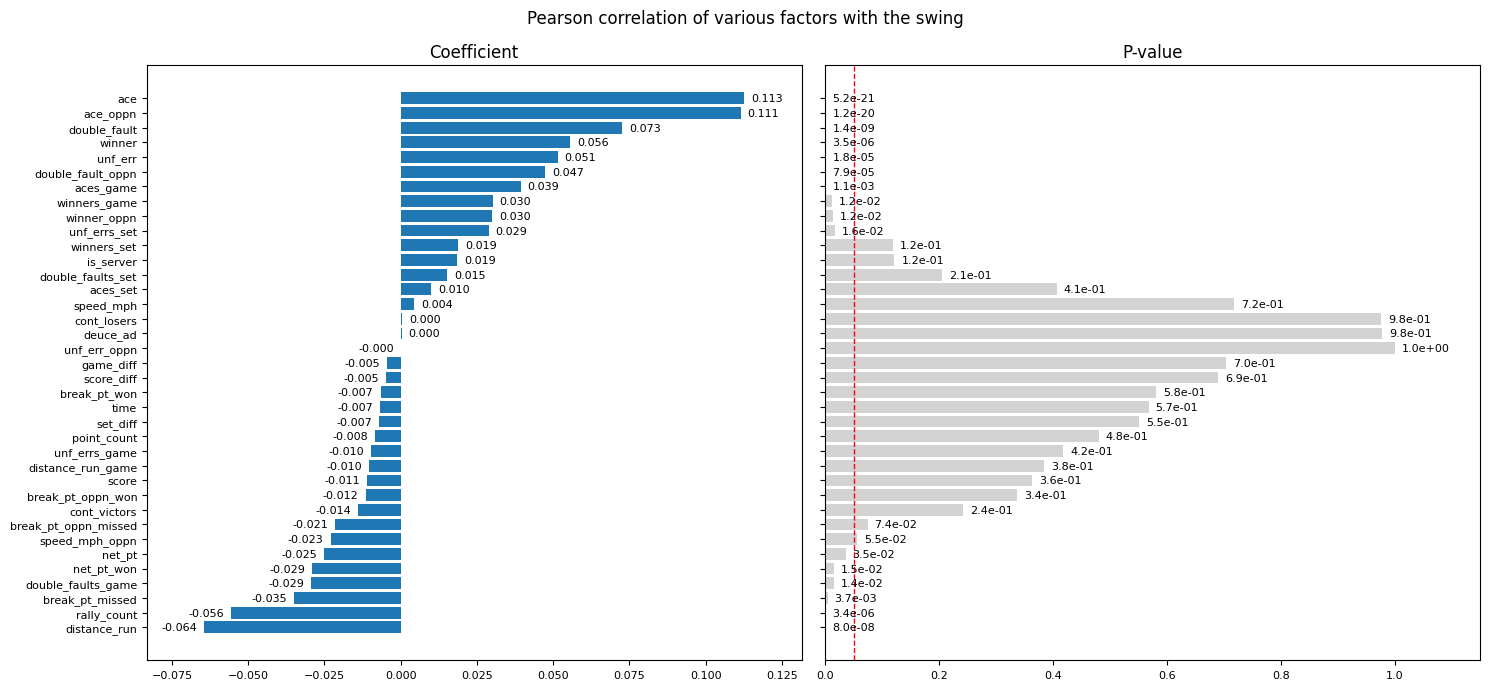

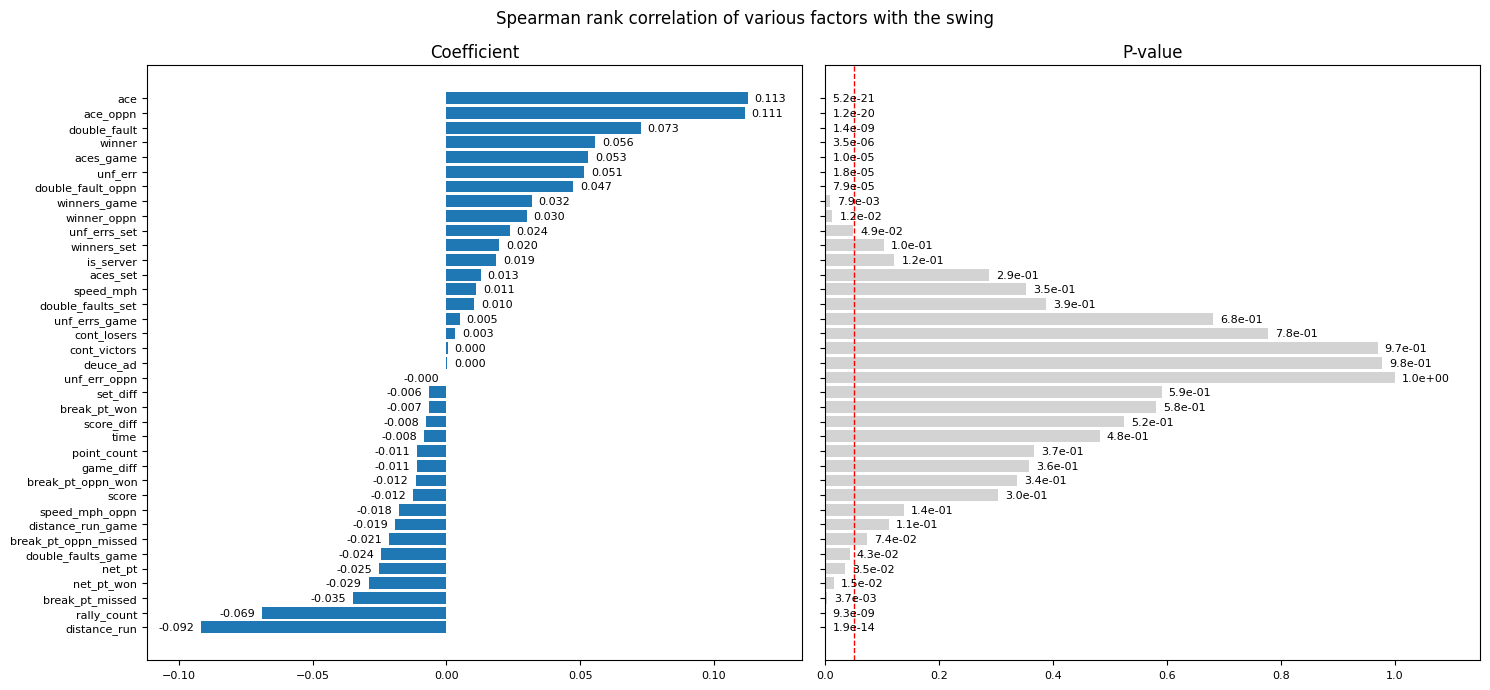

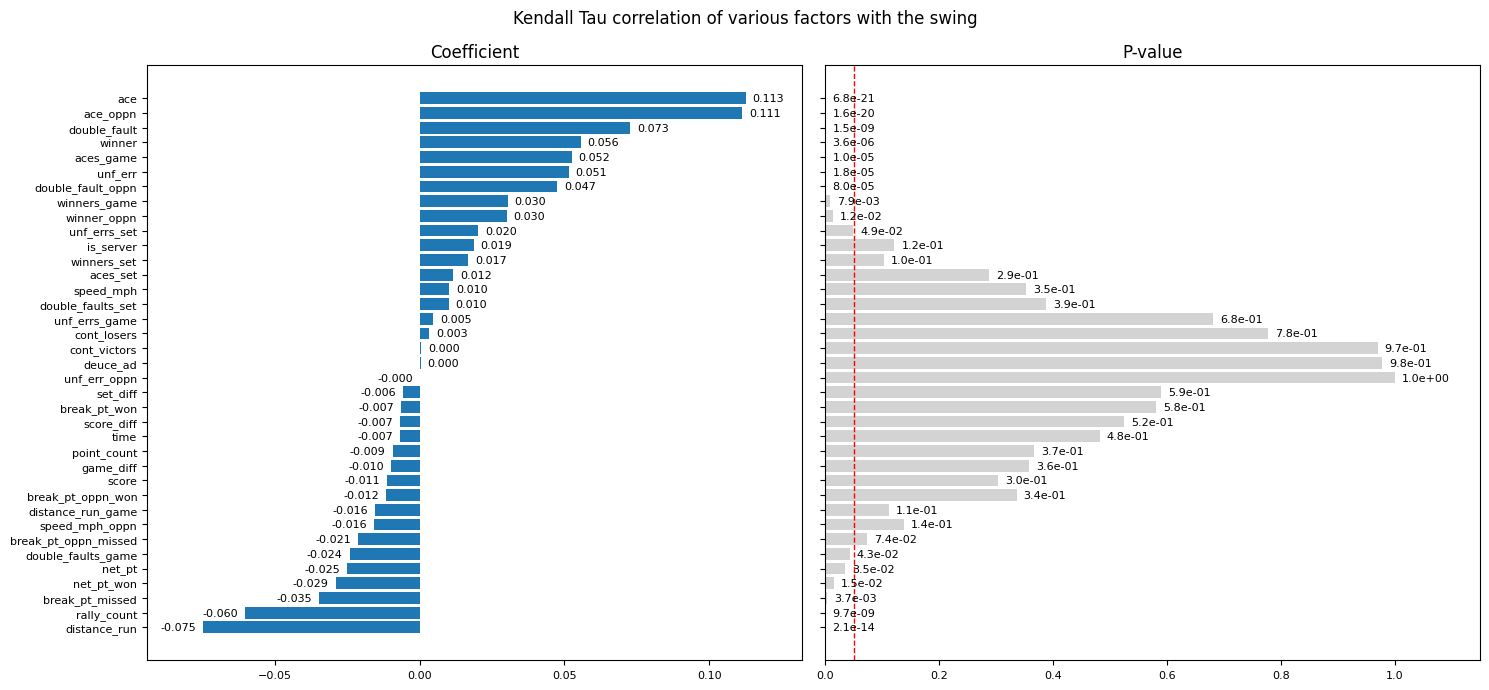

In [26]:
correlation_storage = {}
plot_correlation(df_info, method="pearson", scipy_func=stats.pearsonr, description="Pearson", storage=correlation_storage)
plot_correlation(df_info, method="spearman", scipy_func=stats.spearmanr, description="Spearman rank", storage=correlation_storage)
plot_correlation(df_info, method="kendall", scipy_func=stats.kendalltau, description="Kendall Tau", storage=correlation_storage)

Select a subset of features for the model.

In [27]:
selected_method = "pearson"
selected_corr, selected_corrp = correlation_storage[selected_method]
selected_features = selected_corrp[selected_corrp <= 0.05].index
X, y = df_info[selected_features], df_info["swing"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4649, 16), (2291, 16), (4649,), (2291,))

Heatmap.

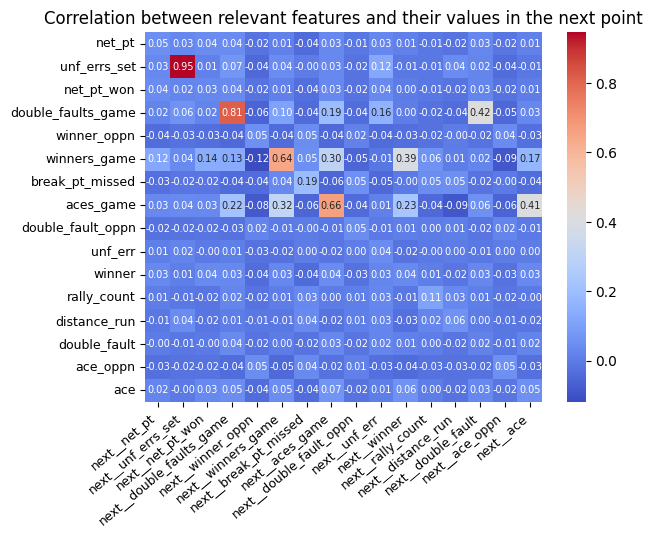

In [28]:
df_info_extension = df_info[selected_features]
cur_cols = df_info_extension.columns
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for col in cur_cols:
        df_info_extension[f"next__{col}"] = df_info_extension[col].shift()
df_info_extension = df_info_extension.dropna()
df_corr_extension = (
    df_info_extension.corr()
    .drop(
        [col for col in df_info_extension.columns if not col.startswith("next__")],
        axis=1,
    )
    .drop(
        [col for col in df_info_extension.columns if col.startswith("next__")], axis=0
    )
)
sns.heatmap(
    df_corr_extension,
    cmap=mpl.colormaps["coolwarm"],
    annot=True,
    annot_kws={"size": 7},
    fmt=".2f",
)
plt.xticks(rotation=40, ha="right", fontsize=9)
plt.yticks(fontsize=9)
plt.title("Correlation between relevant features and their values in the next point")
plt.show()

## Model

The model consists of three steps: (1) standardize the features by removing the mean and scaling to unit variance; (2) over-sampling using SMOTE and cleaning using Tomek links because of the imbalanced dataset; (3) random forest for the classification problem.

In [29]:
no_swing_count = (y == 0).sum()
sampling_strategy = {0: no_swing_count, 1: int(no_swing_count / 5)}
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("sample", SMOTETomek(random_state=42, sampling_strategy=sampling_strategy)),
        ("clf", RandomForestClassifier(random_state=42)),
    ]
)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('sample',
                 SMOTETomek(random_state=42,
                            sampling_strategy={0: 5840, 1: 1168})),
                ('clf', RandomForestClassifier(random_state=42))])

In [30]:
df_feature_importance = pd.DataFrame(
    {"feature": X_train.columns, "importance": pipeline["clf"].feature_importances_}
)
df_feature_importance.sort_values("importance", ascending=False)

feature  importance
12        distance_run    0.449933
1         unf_errs_set    0.233446
11         rally_count    0.128266
5         winners_game    0.070255
7            aces_game    0.022627
3   double_faults_game    0.013436
4          winner_oppn    0.011662
14            ace_oppn    0.010729
9              unf_err    0.010487
0               net_pt    0.009383
15                 ace    0.009176
10              winner    0.008883
8    double_fault_oppn    0.006216
6      break_pt_missed    0.005841
13        double_fault    0.005047
2           net_pt_won    0.004613